# Trojanized Python Packages Detection 
Goal: End‑to‑end reproducible ML pipeline on QUT‑DV25 traces with industry best practices.

- Data: Filetop, Install, Opensnoop, TCP, SysCall, Pattern (processed CSVs)
- Split: 70% train / 15% val / 15% test (stratified) with fixed indices
- Preprocessing: Train‑only fit; numeric cleaning; correlation pruning (train‑fit) with high threshold
- Models: RandomForest, SVM(RBF), GradientBoosting, PyTorch DNN (early stopping)
- Metrics: Accuracy, Precision, Recall, F1, ROC‑AUC, Confusion Matrix, Plots
- Reproducibility: Fixed seeds (numpy/sklearn/torch) and deterministic torch ops where feasible
- Artifacts: Saved models/scalers/vectorizers to OUT_DIR



In [9]:
# Imports & config
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from typing import Tuple, Dict, Optional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import joblib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# PyTorch determinism (best effort)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Paths (same as your Kaggle setup)
DATA_DIR = Path("/kaggle/input/qut-dv25-malware-dataset/QUT-DV25_Datasets/QUT-DV25_Processed_Datasets")
OUT_DIR = Path("/kaggle/working/ai_supplyshield_qut_consolidated")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRACE_FILES = {
    "Filetop": DATA_DIR / "QUT-DV25_Filetop_Traces" / "QUT-DV25_Filetop_Traces.csv",
    "Install": DATA_DIR / "QUT-DV25_Install_Traces" / "QUT-DV25_Install_Traces.csv",
    "Opensnoop": DATA_DIR / "QUT-DV25_Opensnoop_Traces" / "QUT-DV25_Opensnoop_Traces.csv",
    "TCP": DATA_DIR / "QUT-DV25_TCP_Traces" / "QUT-DV25_TCP_Traces.csv",
    "SysCall": DATA_DIR / "QUT-DV25_SysCall_Traces" / "QUT-DV25_SysCall_Traces.csv",
    "Pattern": DATA_DIR / "QUT-DV25_Pattern_Traces" / "QUT-DV25_Pattern_Traces.csv",
}

for name, p in TRACE_FILES.items():
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
print("✅ Processed trace CSVs found.")


✅ Processed trace CSVs found.


In [10]:
# Utilities: loading, cleaning, splits, metrics

def load_csv(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

def detect_label_col(df: pd.DataFrame) -> Optional[str]:
    for c in df.columns:
        if c.lower() in ("label", "level", "target", "class"):
            return c
    return None

def clean_numeric(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    y = df[label_col].astype(int)
    X = df.drop(columns=[label_col])
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X = X[num_cols]
    # drop all-NaN or constant columns
    X = X.dropna(axis=1, how='all')
    nunique = X.nunique(dropna=False)
    X = X.drop(columns=nunique[nunique <= 1].index.tolist(), errors='ignore')
    # replace inf and fill NaN with median
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    return X, y

from sklearn.model_selection import StratifiedShuffleSplit

def make_fixed_split_indices(y: pd.Series, train_size=0.7, val_size=0.15, test_size=0.15, random_state=RANDOM_SEED):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-9
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(1-train_size), random_state=random_state)
    train_idx, temp_idx = next(sss1.split(np.zeros_like(y), y))
    y_temp = y.iloc[temp_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=(test_size/(val_size+test_size)), random_state=random_state)
    val_rel, test_rel = next(sss2.split(np.zeros_like(y_temp), y_temp))
    val_idx = temp_idx[val_rel]
    test_idx = temp_idx[test_rel]
    return train_idx, val_idx, test_idx

# Metrics helpers
from typing import Dict

def compute_metrics(y_true, y_pred, y_score=None) -> Dict[str, float]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = None
    if y_score is not None:
        try:
            roc = roc_auc_score(y_true, y_score)
        except ValueError:
            roc = None
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "roc":roc}

def show_cm(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()



In [11]:
# Transformers: correlation pruning (train-only) + scaler in Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationPruner(BaseEstimator, TransformerMixin):
    def __init__(self, threshold: float = 0.9):
        self.threshold = threshold
        self.keep_columns_: Optional[pd.Index] = None

    def fit(self, X: pd.DataFrame, y=None):
        X_df = pd.DataFrame(X).copy()
        corr = X_df.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > self.threshold)]
        self.keep_columns_ = X_df.columns.difference(to_drop)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        if self.keep_columns_ is None:
            return X_df
        # Align by name when possible
        cols = [c for c in X_df.columns if c in set(self.keep_columns_)]
        return X_df[cols]

from sklearn.pipeline import Pipeline

# Build a standard tabular pipeline: prune -> scale
def make_tabular_pipeline(corr_thresh: float = 0.9) -> Pipeline:
    return Pipeline([
        ("prune", CorrelationPruner(threshold=corr_thresh)),
        ("scale", MinMaxScaler()),
    ])


In [12]:
# Load all traces, clean numeric; encode Pattern with HashingVectorizer+SVD
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

raw_traces: Dict[str, pd.DataFrame] = {}
for name, p in TRACE_FILES.items():
    df = load_csv(p)
    raw_traces[name] = df

# Identify labels per trace
label_map = {}
for name, df in raw_traces.items():
    lbl = detect_label_col(df)
    if not lbl:
        raise ValueError(f"No label in {name}")
    label_map[name] = lbl

numeric_traces: Dict[str, Tuple[pd.DataFrame, pd.Series]] = {}
for name in ["Filetop","Install","Opensnoop","TCP","SysCall"]:
    X, y = clean_numeric(raw_traces[name], label_map[name])
    numeric_traces[name] = (X, y)
    print(f"{name}: {X.shape} | labels: {int((y==0).sum())}/{int((y==1).sum())}")

# Pattern trace encoding
pat_df = raw_traces["Pattern"].copy()
pat_label = label_map["Pattern"]
y_pat = pat_df[pat_label].astype(int)
X_pat_raw = pat_df.drop(columns=[pat_label])
# concatenate non-numeric as text sequence
text_cols = X_pat_raw.select_dtypes(exclude=[np.number]).columns.tolist()
if len(text_cols) == 0:
    text_cols = X_pat_raw.columns.tolist()
seq_series = X_pat_raw[text_cols].astype(str).agg(" ".join, axis=1)

hv = HashingVectorizer(n_features=2048, alternate_sign=False, norm='l2', ngram_range=(1,2), analyzer='word')
X_hash = hv.transform(seq_series.values)
svd = TruncatedSVD(n_components=50, random_state=RANDOM_SEED)
X_pat = svd.fit_transform(X_hash)
X_pat_df = pd.DataFrame(X_pat, columns=[f"pat_svd_{i}" for i in range(X_pat.shape[1])])

numeric_traces["Pattern"] = (X_pat_df, y_pat)

# Save text models
joblib.dump(hv, OUT_DIR / "pattern_hashing_vectorizer.joblib")
joblib.dump(svd, OUT_DIR / "pattern_truncated_svd.joblib")
print("Pattern encoding complete:", X_pat_df.shape)


Filetop: (14271, 4) | labels: 7144/7127
Install: (14271, 3) | labels: 7144/7127
Opensnoop: (14271, 12) | labels: 7144/7127
TCP: (14271, 7) | labels: 7144/7127
SysCall: (14271, 22) | labels: 7144/7127
Pattern encoding complete: (14271, 50)


In [13]:
# Build fixed split indices based on a reference label (Filetop)
ref_y = numeric_traces["Filetop"][1].reset_index(drop=True)
train_idx, val_idx, test_idx = make_fixed_split_indices(ref_y, 0.7, 0.15, 0.15, RANDOM_SEED)
print(len(train_idx), len(val_idx), len(test_idx))

# Helper to apply the same indices across traces
def split_by_indices(X: pd.DataFrame, y: pd.Series):
    Xr = X.reset_index(drop=True)
    yr = y.reset_index(drop=True)
    return (
        Xr.iloc[train_idx], Xr.iloc[val_idx], Xr.iloc[test_idx],
        yr.iloc[train_idx], yr.iloc[val_idx], yr.iloc[test_idx]
    )


9989 2141 2141


In [14]:
# Training utilities: classical models and DNN with early stopping
class TabularDataset(Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.Series):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class SimpleDNN(nn.Module):
    def __init__(self, in_dim: int, hidden=[256,128,64], dropout=0.2):
        super().__init__()
        layers=[]; prev=in_dim
        for h in hidden:
            layers.extend([nn.Linear(prev,h), nn.BatchNorm1d(h), nn.ReLU(inplace=True), nn.Dropout(dropout)])
            prev=h
        layers.append(nn.Linear(prev,1))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x).squeeze(1)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

def train_eval_dnn(Xtr, ytr, Xva, yva, Xte, yte, epochs=40, batch=256, lr=1e-3):
    model = SimpleDNN(in_dim=Xtr.shape[1]).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

    tr_loader = DataLoader(TabularDataset(Xtr,ytr), batch_size=batch, shuffle=True, num_workers=2, pin_memory=True)
    va_loader = DataLoader(TabularDataset(Xva,yva), batch_size=batch, shuffle=False, num_workers=2)
    te_loader = DataLoader(TabularDataset(Xte,yte), batch_size=batch, shuffle=False, num_workers=2)

    best_val = float("inf"); patience=6; bad=0
    for ep in range(1, epochs+1):
        model.train(); losses=[]
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt); scaler.update()
            losses.append(loss.item())
        # val
        model.eval(); vloss=[]
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            for xb, yb in va_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                lv = criterion(model(xb), yb)
                vloss.append(lv.item())
        mean_tr = float(np.mean(losses)); mean_va = float(np.mean(vloss))
        if ep==1 or ep%5==0:
            print(f"Epoch {ep:02d}/{epochs} train={mean_tr:.4f} val={mean_va:.4f}")
        if mean_va < best_val - 1e-4:
            best_val = mean_va; bad=0
            torch.save(model.state_dict(), OUT_DIR/"best_dnn.pth")
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping."); break

    model.load_state_dict(torch.load(OUT_DIR/"best_dnn.pth", map_location=DEVICE))
    # test
    model.eval(); y_true=[]; y_pred=[]; y_score=[]
    with torch.no_grad():
        for xb, yb in te_loader:
            xb = xb.to(DEVICE)
            logits = model(xb).cpu().numpy()
            probs = 1/(1+np.exp(-logits))
            preds = (probs>0.5).astype(int)
            y_true.extend(yb.numpy().astype(int).tolist())
            y_pred.extend(preds.tolist())
            y_score.extend(probs.tolist())
    return model, y_true, y_pred, y_score

def train_eval_classical(Xtr, ytr, Xte, yte):
    results = {}
    # RF
    rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=RANDOM_SEED, n_jobs=-1)
    rf.fit(Xtr, ytr)
    ypr = rf.predict(Xte); ysc = rf.predict_proba(Xte)[:,1]
    results["RF"] = (rf, compute_metrics(yte, ypr, ysc))
    # SVM RBF (with probability for ROC)
    svm = SVC(kernel='rbf', C=2.0, gamma='scale', probability=True, random_state=RANDOM_SEED)
    svm.fit(Xtr, ytr)
    ypr = svm.predict(Xte); ysc = svm.predict_proba(Xte)[:,1]
    results["SVM_RBF"] = (svm, compute_metrics(yte, ypr, ysc))
    # GB
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED)
    gb.fit(Xtr, ytr)
    ypr = gb.predict(Xte); ysc = gb.predict_proba(Xte)[:,1] if hasattr(gb, "predict_proba") else None
    results["GB"] = (gb, compute_metrics(yte, ypr, ysc))
    return results


Using device: cuda


In [19]:
# ROC curve helper (placed early so it's available below)
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_score, title: str):
    if y_score is None:
        print(f"{title}: No probability scores available; skipping ROC curve.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


Combining: ['Filetop', 'Install', 'Opensnoop', 'TCP', 'SysCall', 'Pattern']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


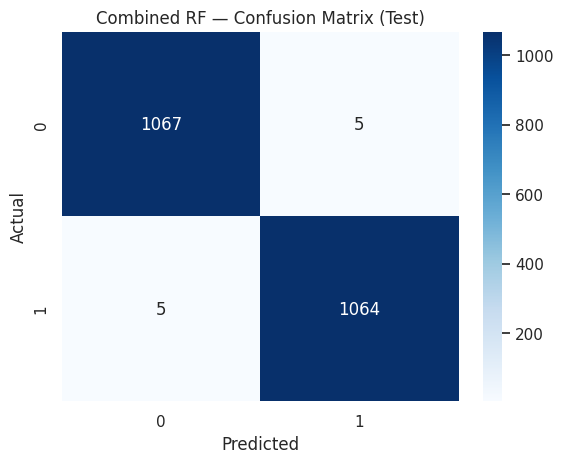

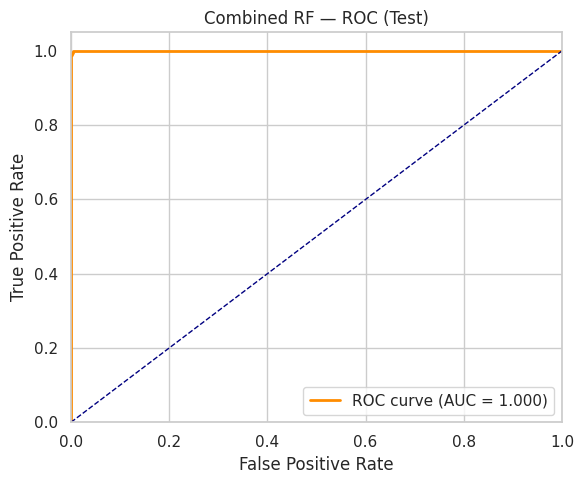

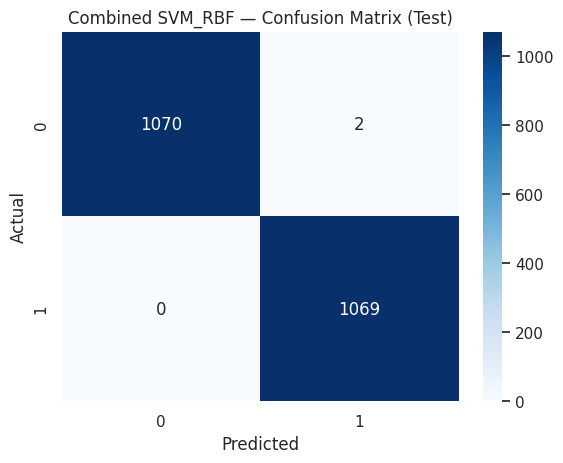

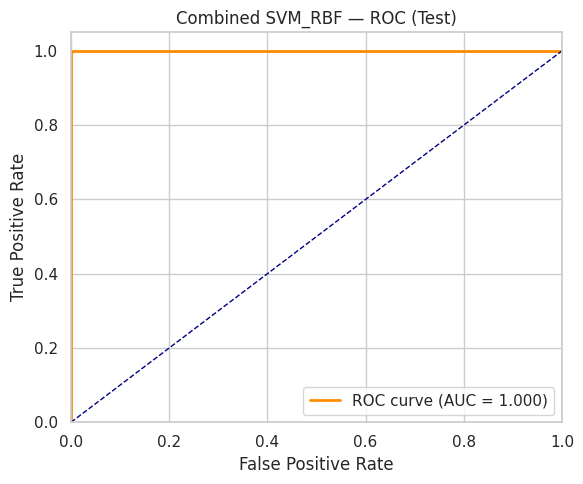

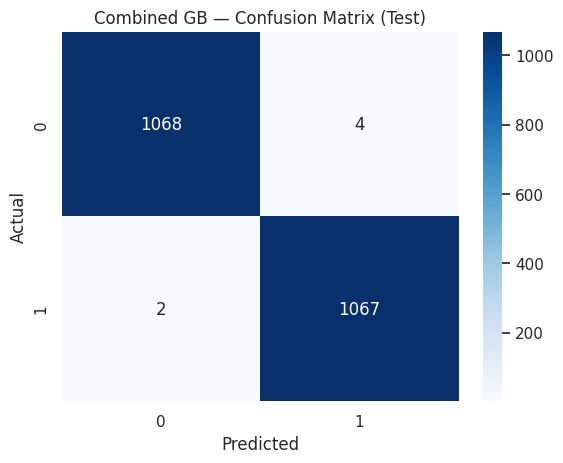

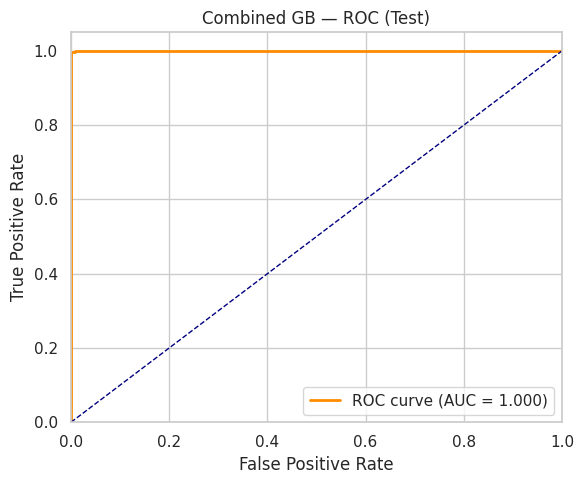

/tmp/ipykernel_37/1958374311.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/tmp/ipykernel_37/1958374311.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
/tmp/ipykernel_37/1958374311.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/40 train=0.2693 val=0.1787
Epoch 05/40 train=0.0015 val=0.0002
Epoch 10/40 train=0.0000 val=0.0000
Early stopping.


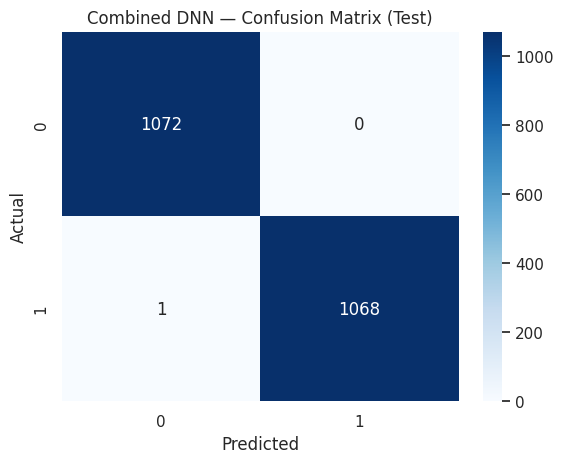

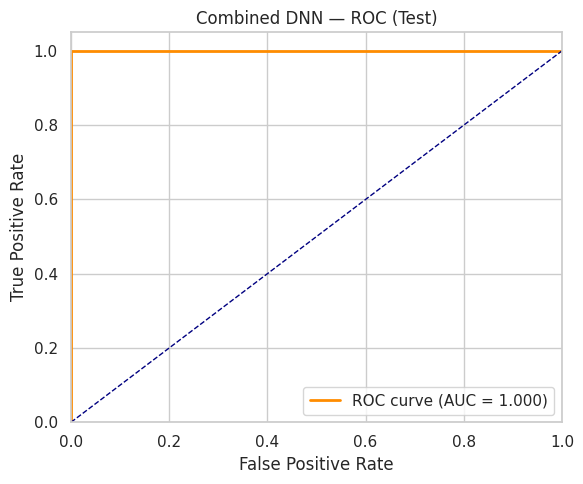

,trace,model,acc,prec,rec,f1,roc
0,Combined,RF,0.995329,0.995323,0.995323,0.995323,0.999954
1,Combined,SVM_RBF,0.999066,0.998133,1.000000,0.999065,0.999997
2,Combined,GB,0.997198,0.996265,0.998129,0.997196,0.999970
3,Combined,DNN,0.999533,1.000000,0.999065,0.999532,1.000000


Saved: /kaggle/working/ai_supplyshield_qut_consolidated/combined_results.csv


In [20]:
# Combine traces horizontally, then train with same leak-free pipeline
valid_names = list(numeric_traces.keys())
print("Combining:", valid_names)

combined_X = pd.concat([numeric_traces[n][0].reset_index(drop=True) for n in valid_names], axis=1)
combined_y = numeric_traces[valid_names[0]][1].reset_index(drop=True)  # aligned

Xtr, Xva, Xte, ytr, yva, yte = split_by_indices(combined_X, combined_y)
pipe_c = make_tabular_pipeline(corr_thresh=0.9)
Xtr_s = pipe_c.fit_transform(Xtr, ytr)
Xva_s = pipe_c.transform(Xva)
Xte_s = pipe_c.transform(Xte)

cols = [f"c_{i}" for i in range(Xtr_s.shape[1])]
Xtr_df = pd.DataFrame(Xtr_s, columns=cols)
Xva_df = pd.DataFrame(Xva_s, columns=cols)
Xte_df = pd.DataFrame(Xte_s, columns=cols)

# Classical models
comb_results = train_eval_classical(Xtr_df, ytr, Xte_df, yte)
rows=[]
for mname, (mdl, mets) in comb_results.items():
    rows.append({"trace":"Combined","model":mname, **mets})
    joblib.dump(mdl, OUT_DIR / f"{mname.lower()}_combined.joblib")
    # Test-only plots
    y_pred_m = mdl.predict(Xte_df)
    y_score_m = mdl.predict_proba(Xte_df)[:,1] if hasattr(mdl, "predict_proba") else None
    show_cm(yte, y_pred_m, title=f"Combined {mname} — Confusion Matrix (Test)")
    plot_roc(yte, y_score_m, title=f"Combined {mname} — ROC (Test)")

# DNN
comb_dnn, y_true_c, y_pred_c, y_score_c = train_eval_dnn(Xtr_df, ytr, Xva_df, yva, Xte_df, yte, epochs=40, batch=256)
rows.append({"trace":"Combined","model":"DNN", **compute_metrics(y_true_c, y_pred_c, y_score_c)})
# Test-only plots
show_cm(y_true_c, y_pred_c, title="Combined DNN — Confusion Matrix (Test)")
plot_roc(y_true_c, y_score_c, title="Combined DNN — ROC (Test)")

# Save pipeline
joblib.dump(pipe_c, OUT_DIR / "pipeline_combined.pkl")

comb_df = pd.DataFrame(rows)[["trace","model","acc","prec","rec","f1","roc"]]
display(comb_df)
comb_df.to_csv(OUT_DIR / "combined_results.csv", index=False)
print("Saved:", OUT_DIR / "combined_results.csv")



=== Trace: Filetop ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


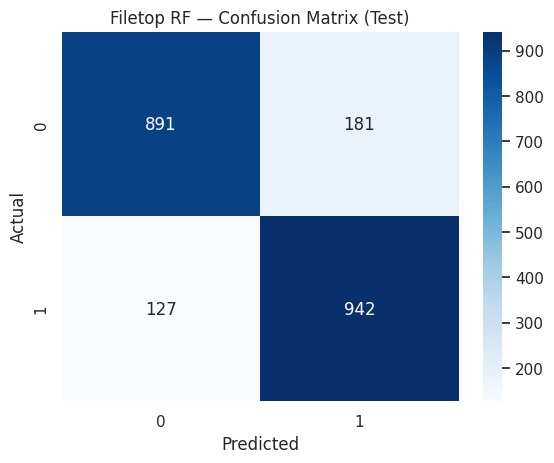

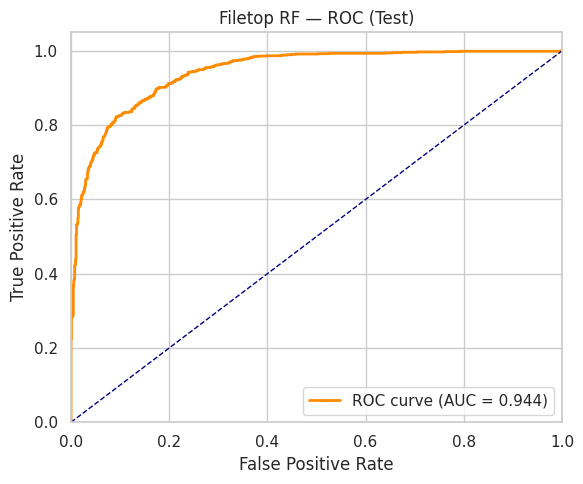

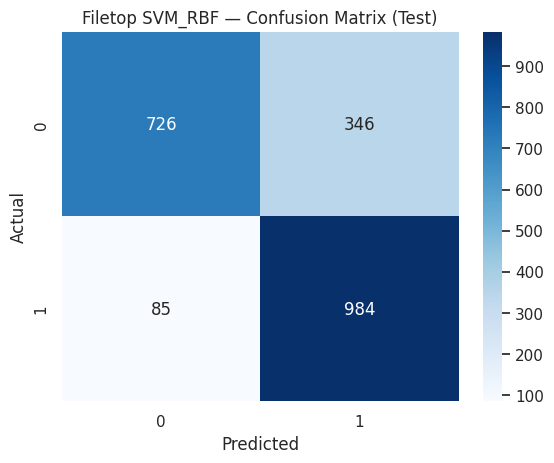

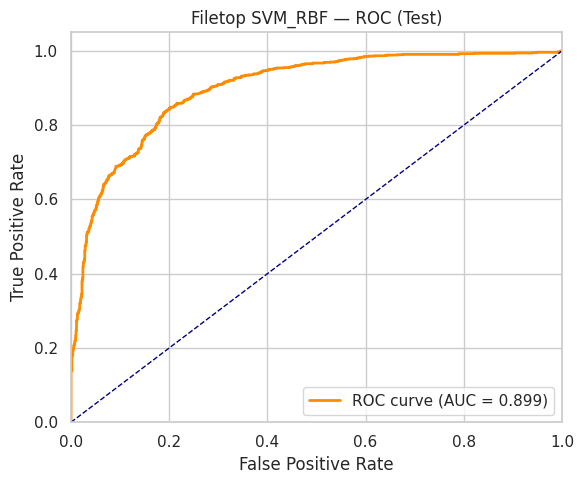

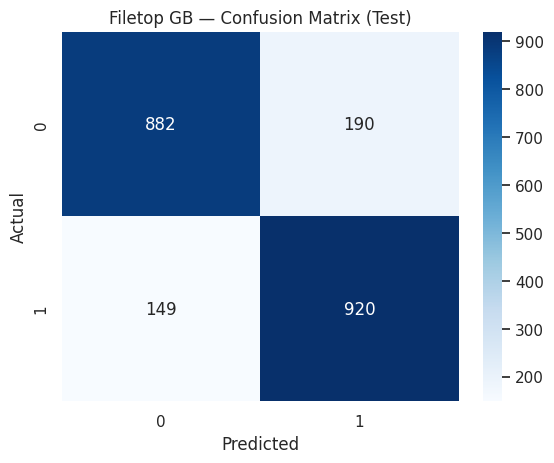

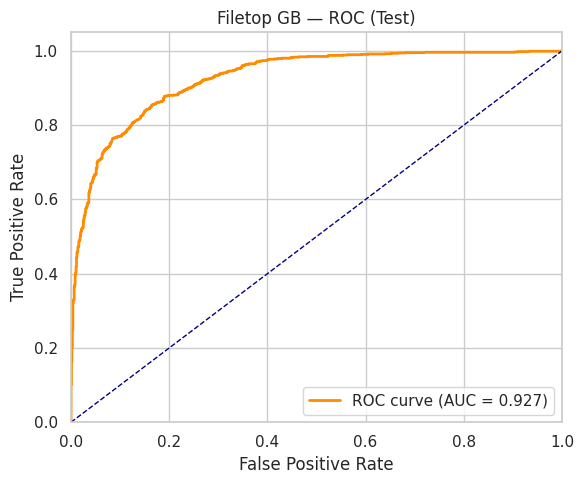

/tmp/ipykernel_37/1958374311.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/tmp/ipykernel_37/1958374311.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
/tmp/ipykernel_37/1958374311.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/35 train=0.5084 val=0.6500
Epoch 05/35 train=0.3824 val=0.3316
Epoch 10/35 train=0.3725 val=0.3229
Epoch 15/35 train=0.3349 val=0.3424
Epoch 20/35 train=0.3256 val=0.3098
Early stopping.


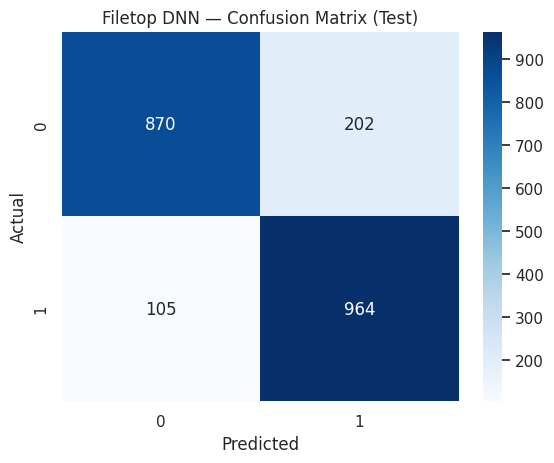

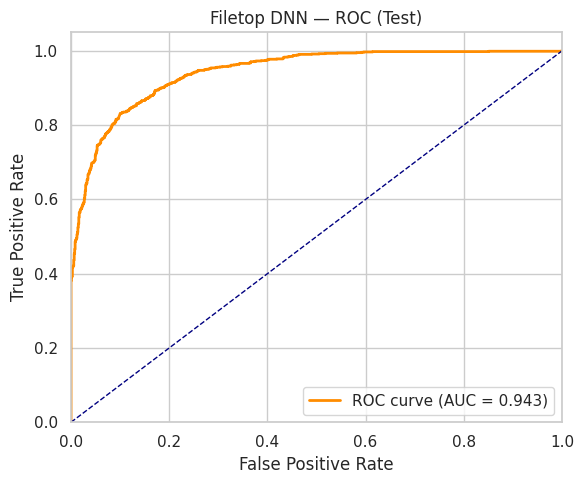


=== Trace: Install ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


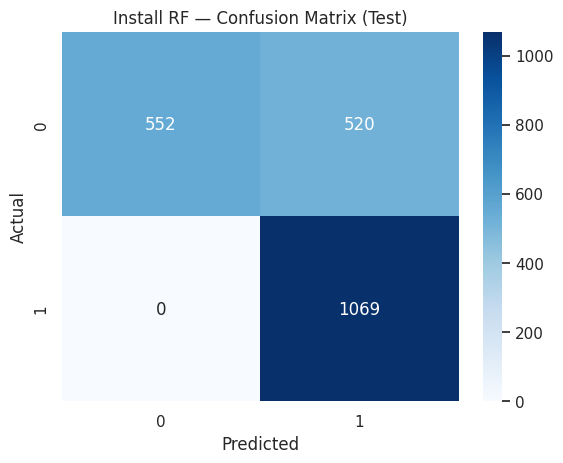

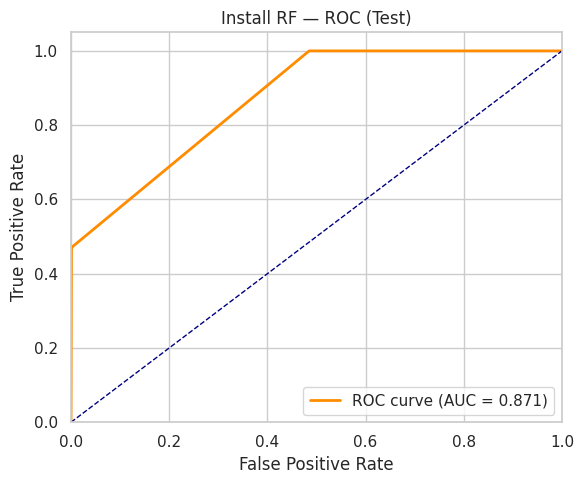

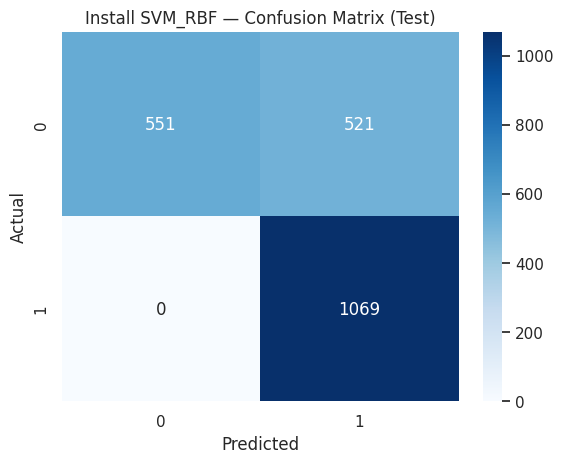

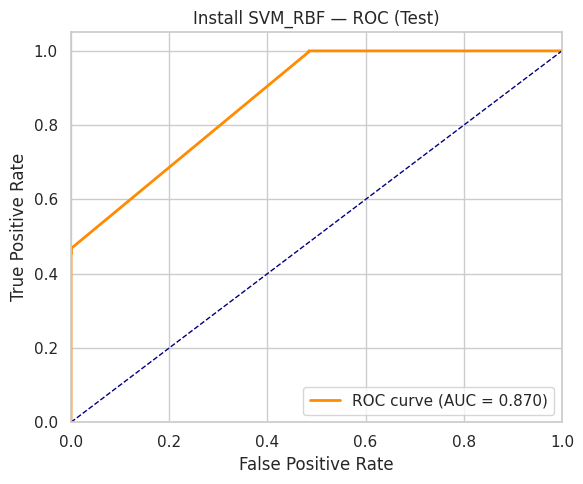

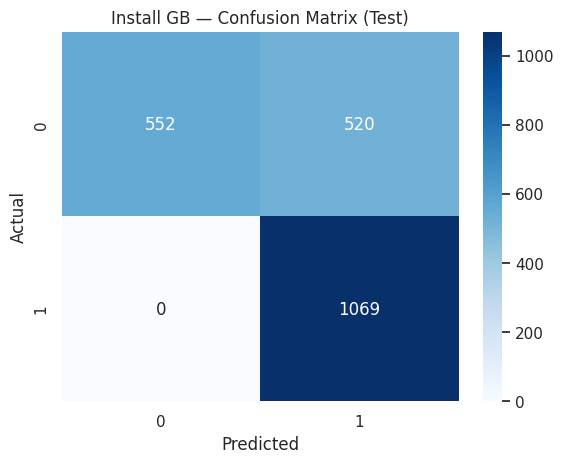

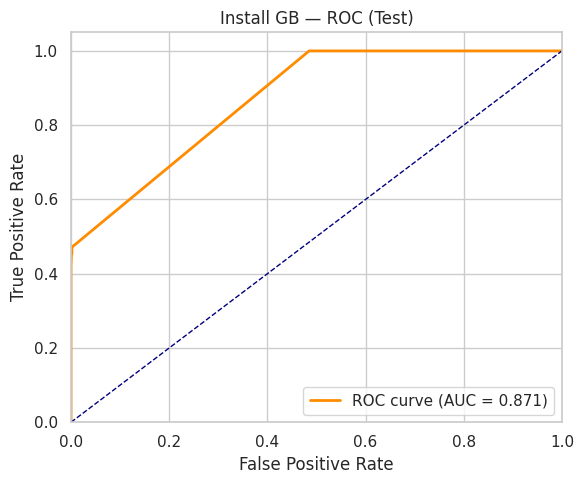

/tmp/ipykernel_37/1958374311.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/tmp/ipykernel_37/1958374311.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
/tmp/ipykernel_37/1958374311.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/35 train=0.4977 val=1.0894
Epoch 05/35 train=0.3928 val=0.3650
Epoch 10/35 train=0.3651 val=0.4097
Early stopping.


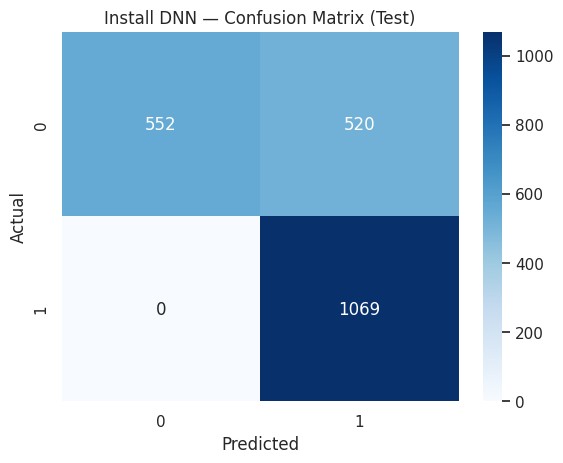

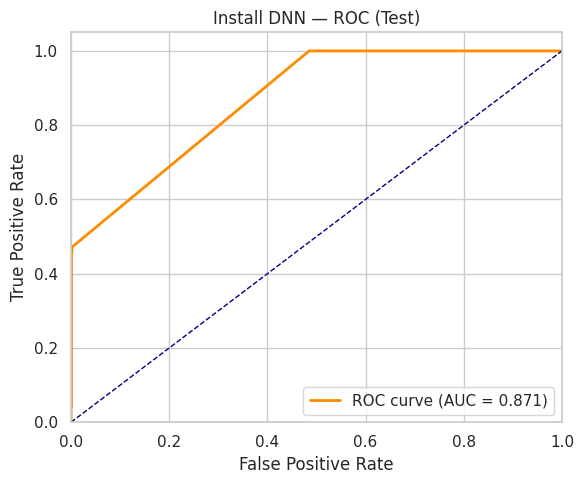


=== Trace: Opensnoop ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


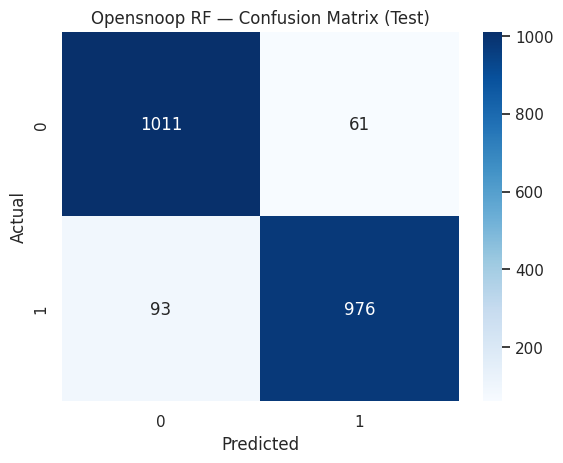

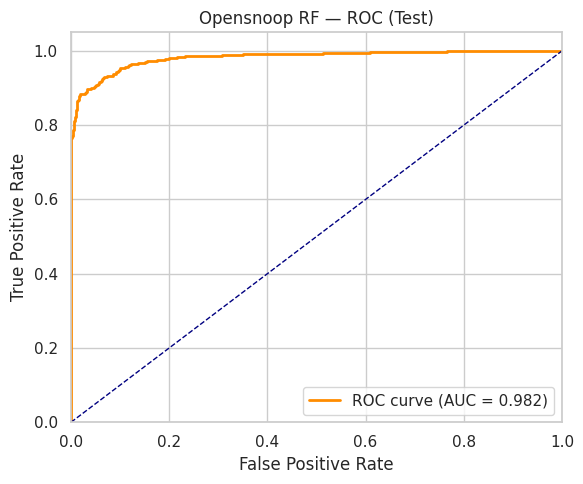

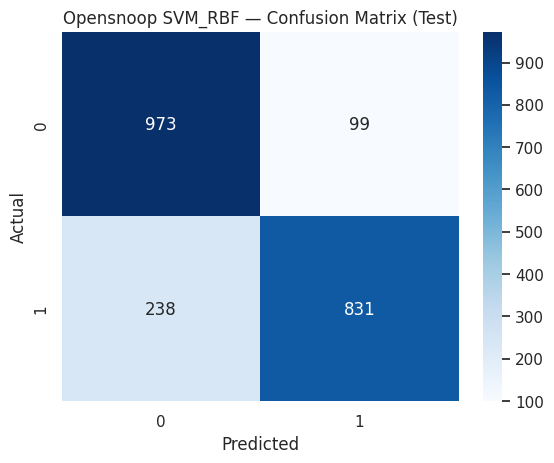

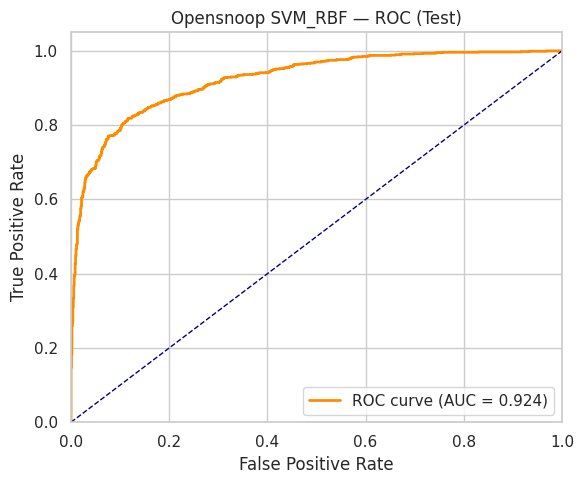

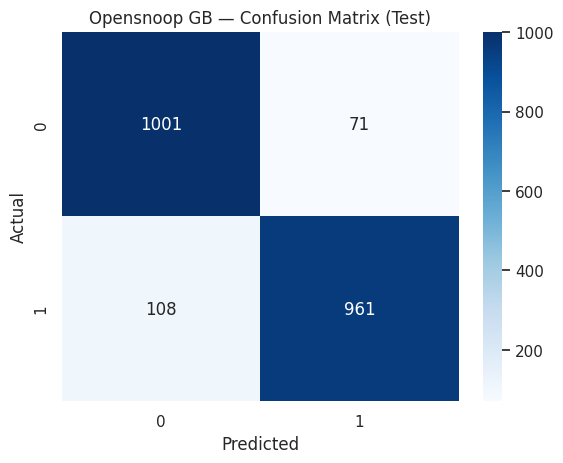

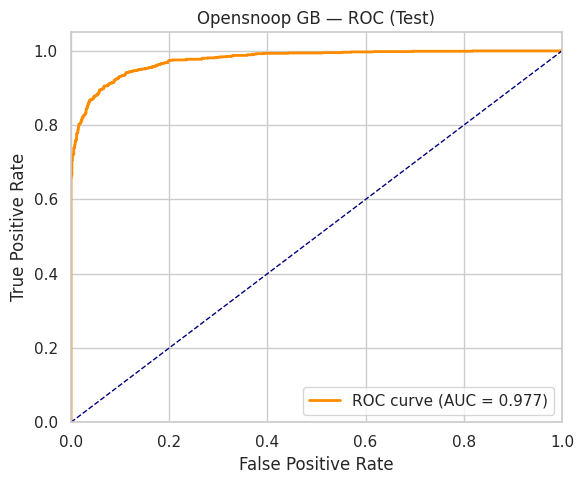

/tmp/ipykernel_37/1958374311.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/tmp/ipykernel_37/1958374311.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
/tmp/ipykernel_37/1958374311.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/35 train=0.5098 val=0.6383
Epoch 05/35 train=0.3235 val=0.2884
Epoch 10/35 train=0.3076 val=0.2749
Epoch 15/35 train=0.2895 val=0.2576
Epoch 20/35 train=0.2698 val=0.2379
Epoch 25/35 train=0.2489 val=0.2338
Epoch 30/35 train=0.3123 val=0.2220
Epoch 35/35 train=0.2347 val=0.2344


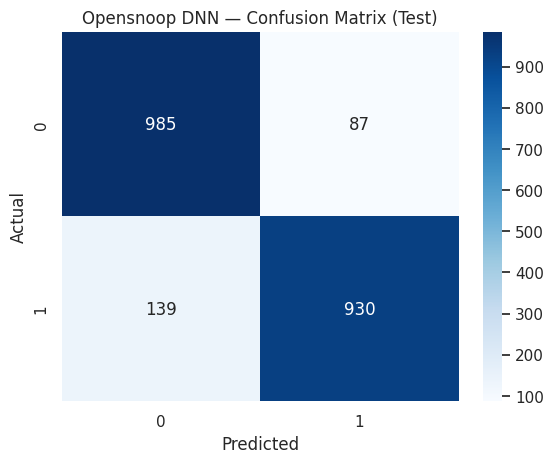

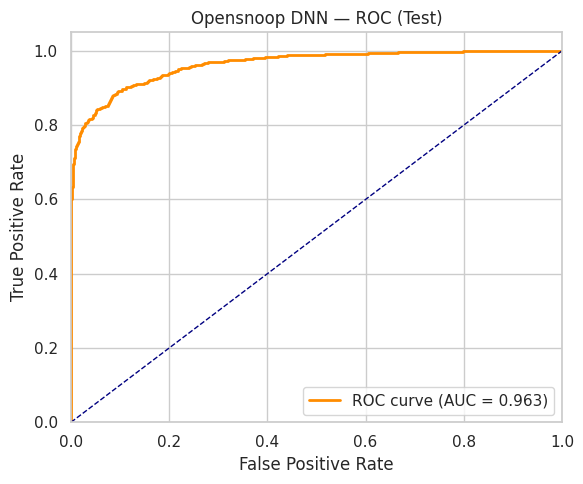


=== Trace: TCP ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


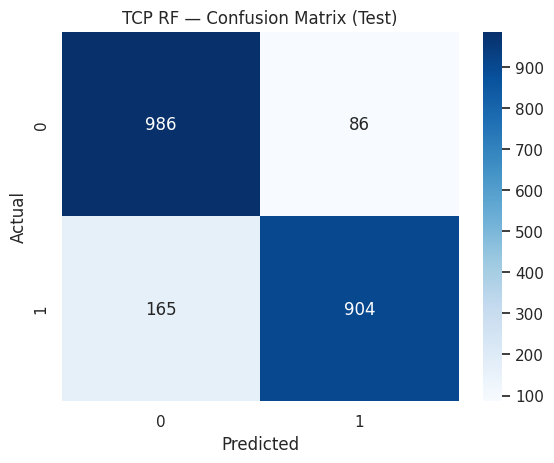

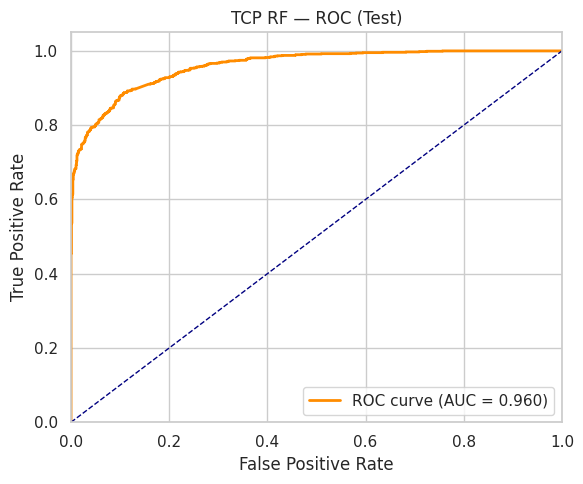

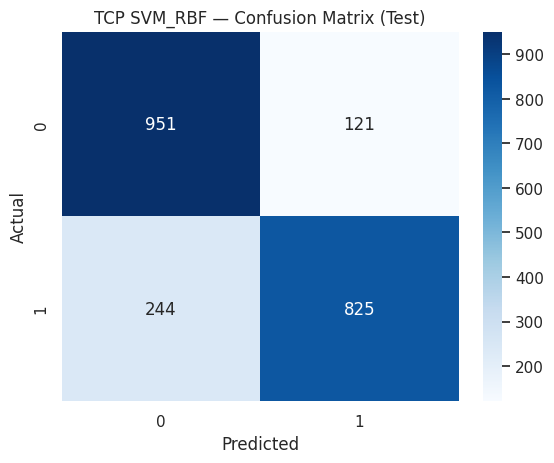

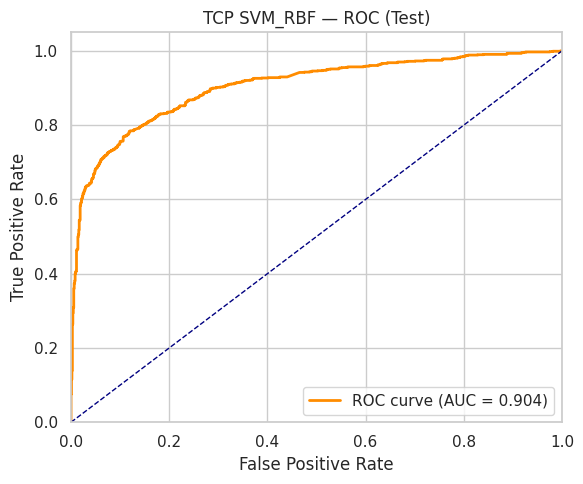

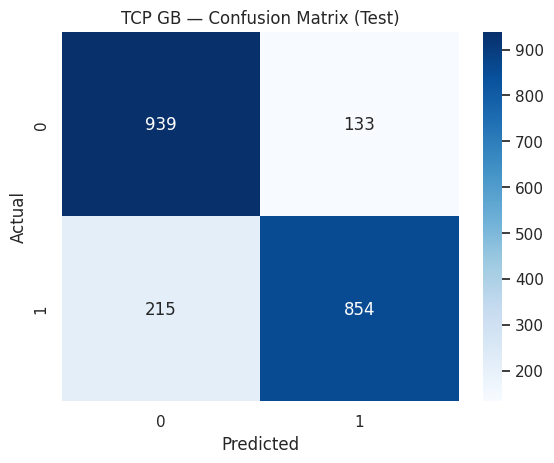

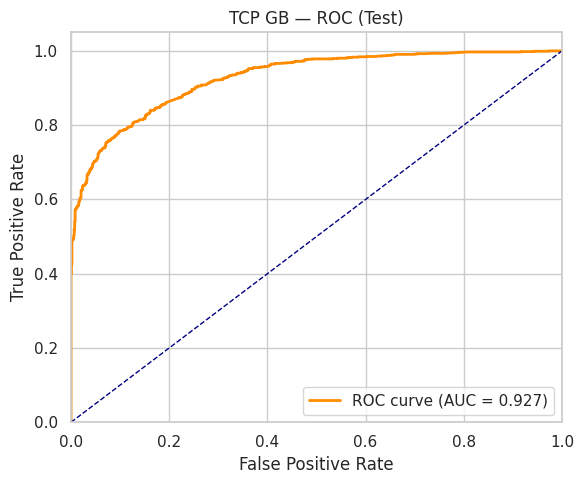

/tmp/ipykernel_37/1958374311.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/tmp/ipykernel_37/1958374311.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
/tmp/ipykernel_37/1958374311.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/35 train=0.5068 val=0.5540
Epoch 05/35 train=0.3807 val=0.3598
Epoch 10/35 train=0.3665 val=0.3502
Epoch 15/35 train=0.3543 val=0.3575
Epoch 20/35 train=0.3581 val=0.3272
Epoch 25/35 train=0.3313 val=0.3291
Epoch 30/35 train=0.3547 val=0.3231
Epoch 35/35 train=0.3431 val=0.3251
Early stopping.


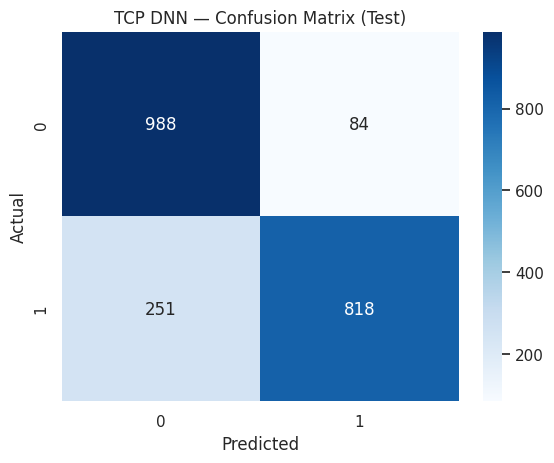

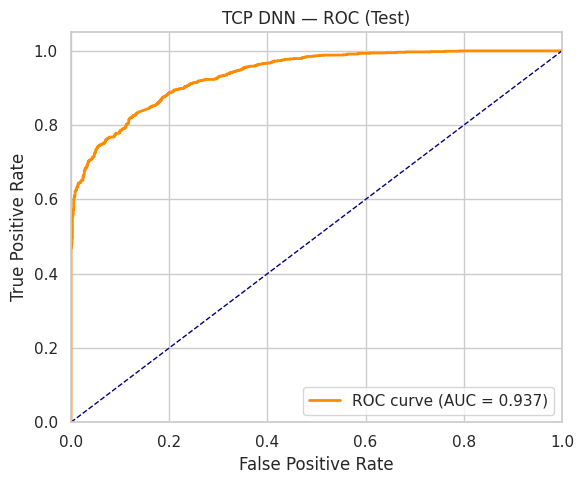


=== Trace: SysCall ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


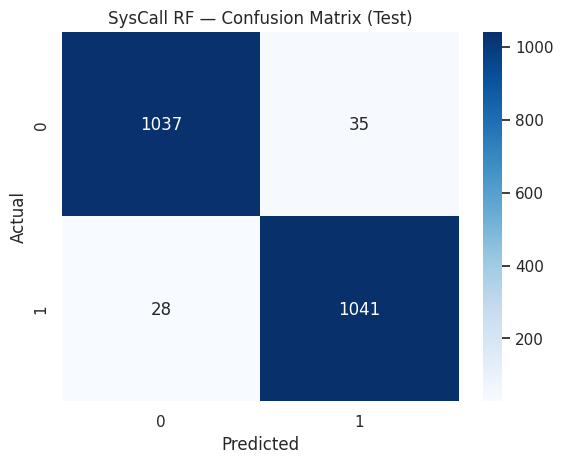

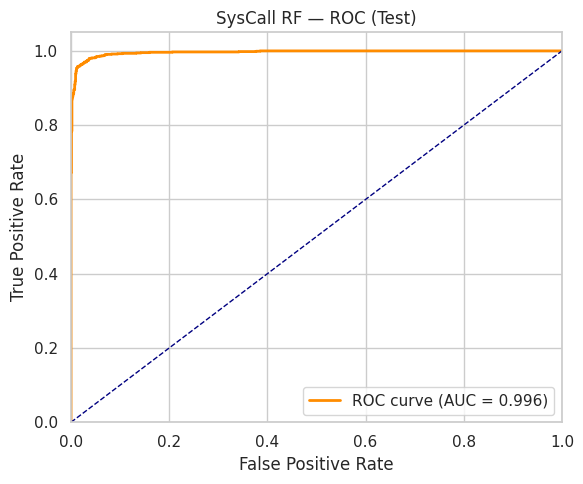

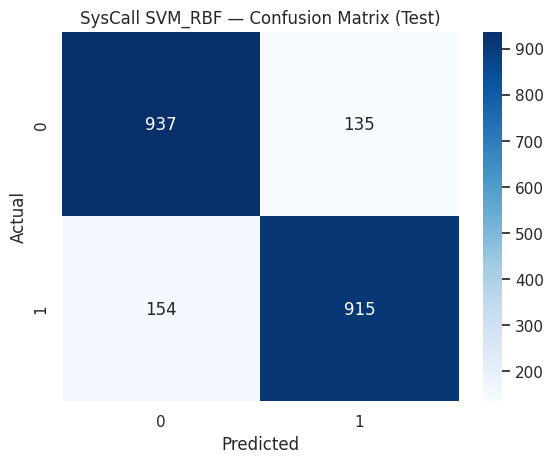

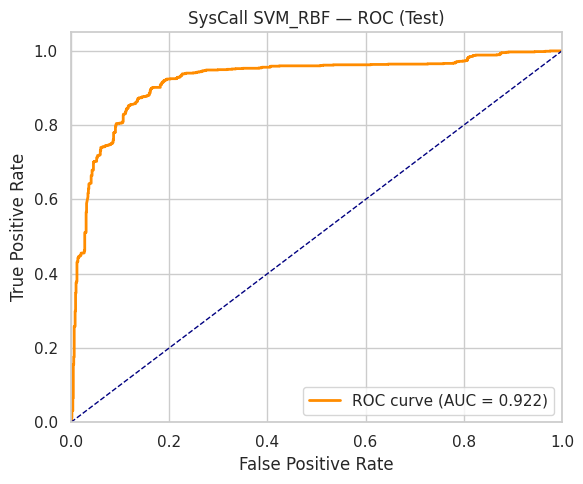

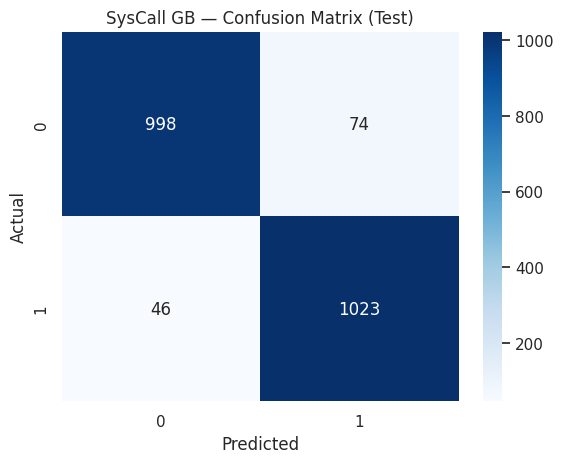

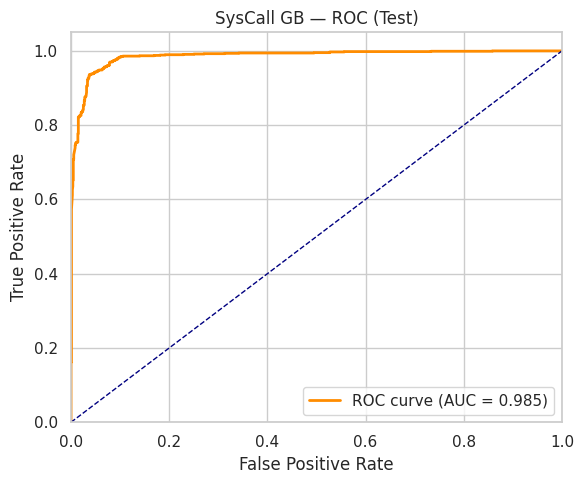

/tmp/ipykernel_37/1958374311.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/tmp/ipykernel_37/1958374311.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
/tmp/ipykernel_37/1958374311.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/35 train=0.4364 val=0.3940
Epoch 05/35 train=0.2471 val=0.2350
Epoch 10/35 train=0.1839 val=0.1826
Epoch 15/35 train=0.2133 val=0.1521
Epoch 20/35 train=0.1476 val=0.1456
Epoch 25/35 train=0.1464 val=0.1743
Epoch 30/35 train=0.1855 val=0.1516
Early stopping.


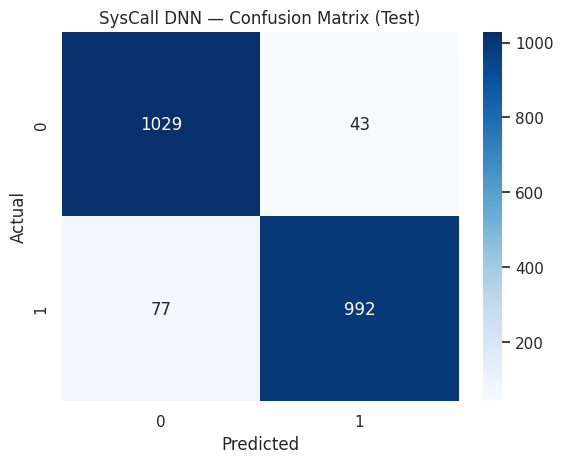

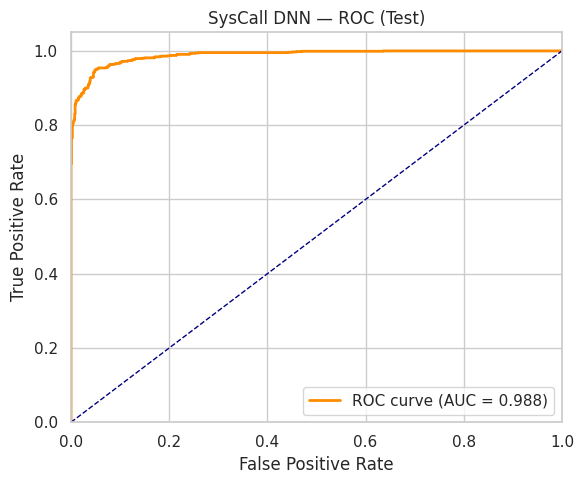


=== Trace: Pattern ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


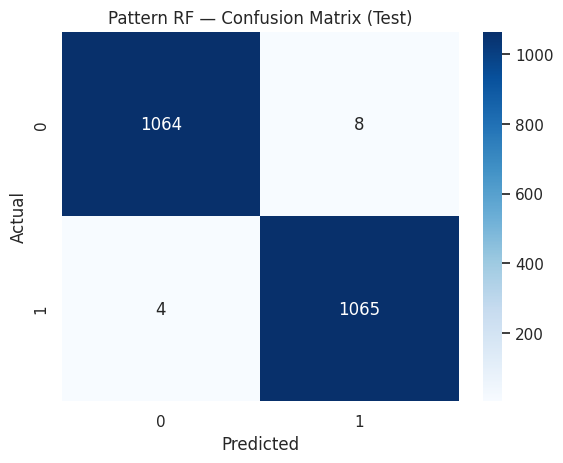

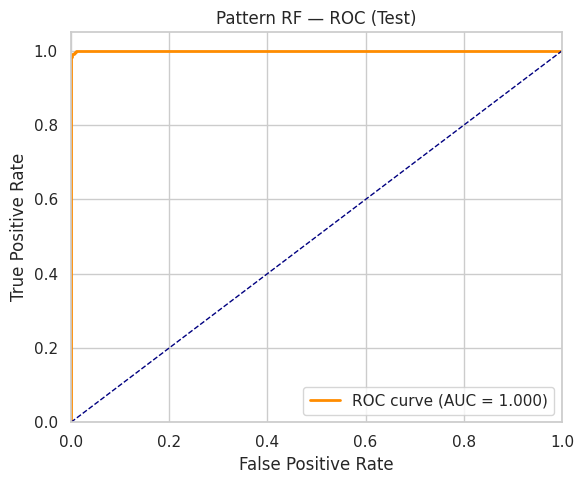

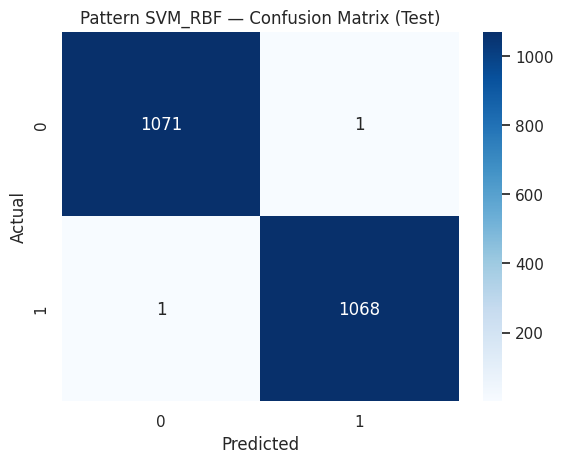

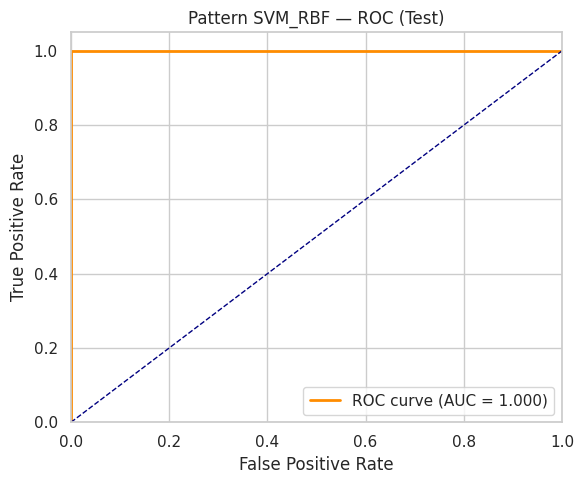

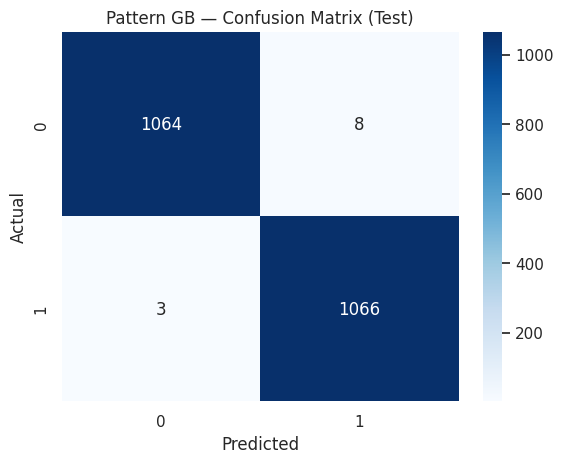

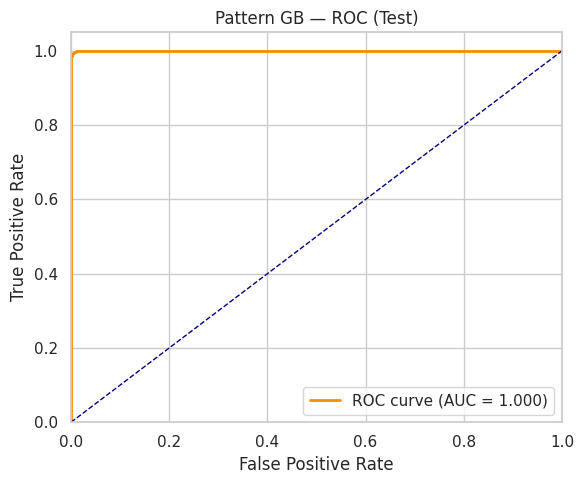

/tmp/ipykernel_37/1958374311.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/tmp/ipykernel_37/1958374311.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
/tmp/ipykernel_37/1958374311.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01/35 train=0.2665 val=0.1775
Epoch 05/35 train=0.0024 val=0.0000
Epoch 10/35 train=0.0027 val=0.0000
Early stopping.


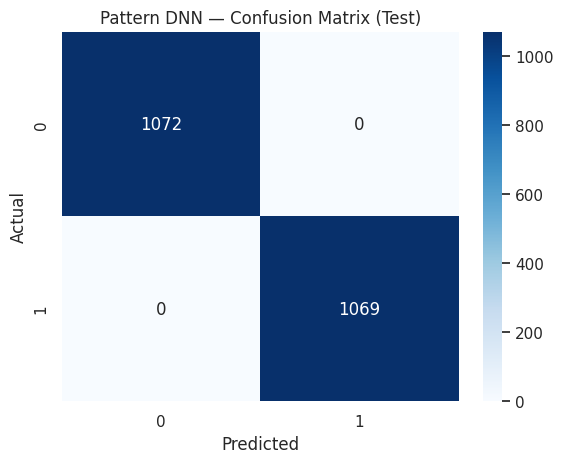

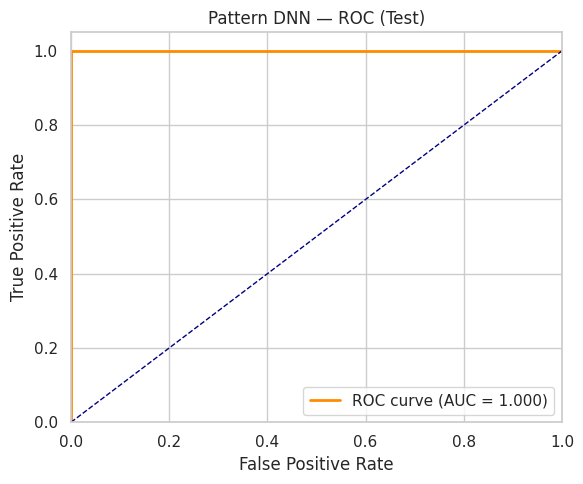

,trace,model,acc,prec,rec,f1,roc
3,Filetop,DNN,0.856609,0.826758,0.901777,0.862640,0.942813
2,Filetop,GB,0.841663,0.828829,0.860617,0.844424,0.927050
0,Filetop,RF,0.856142,0.838825,0.881197,0.859489,0.944010
1,Filetop,SVM_RBF,0.798692,0.739850,0.920486,0.820342,0.899012
7,Install,DNN,0.757123,0.672750,1.000000,0.804364,0.870904
6,Install,GB,0.757123,0.672750,1.000000,0.804364,0.871270
4,Install,RF,0.757123,0.672750,1.000000,0.804364,0.871093
5,Install,SVM_RBF,0.756656,0.672327,1.000000,0.804062,0.870440
11,Opensnoop,DNN,0.894442,0.914454,0.869972,0.891659,0.963416
10,Opensnoop,GB,0.916394,0.931202,0.898971,0.914802,0.976510


Saved: /kaggle/working/ai_supplyshield_qut_consolidated/per_trace_results.csv


In [21]:
# Train & evaluate per-trace with train-only pipeline
results_rows = []
trace_artifacts = {}

for trace_name, (X, y) in numeric_traces.items():
    print(f"\n=== Trace: {trace_name} ===")
    Xtr, Xva, Xte, ytr, yva, yte = split_by_indices(X, y)
    pipe = make_tabular_pipeline(corr_thresh=0.9)
    # Fit on train only
    Xtr_s = pipe.fit_transform(Xtr, ytr)
    Xva_s = pipe.transform(Xva)
    Xte_s = pipe.transform(Xte)
    # to DataFrame for model APIs that expect columns
    cols = [f"f_{i}" for i in range(Xtr_s.shape[1])]
    Xtr_df = pd.DataFrame(Xtr_s, columns=cols)
    Xva_df = pd.DataFrame(Xva_s, columns=cols)
    Xte_df = pd.DataFrame(Xte_s, columns=cols)

    # Classical models
    cls_results = train_eval_classical(Xtr_df, ytr, Xte_df, yte)
    for mname, (mdl, mets) in cls_results.items():
        results_rows.append({"trace": trace_name, "model": mname, **mets})
        # save
        joblib.dump(mdl, OUT_DIR / f"{mname.lower()}_{trace_name}.joblib")
        # Test-only confusion matrix and ROC
        y_pred_m = mdl.predict(Xte_df)
        y_score_m = mdl.predict_proba(Xte_df)[:,1] if hasattr(mdl, "predict_proba") else None
        show_cm(yte, y_pred_m, title=f"{trace_name} {mname} — Confusion Matrix (Test)")
        plot_roc(yte, y_score_m, title=f"{trace_name} {mname} — ROC (Test)")

    # DNN
    dnn, y_true, y_pred, y_score = train_eval_dnn(Xtr_df, ytr, Xva_df, yva, Xte_df, yte, epochs=35, batch=256)
    dnn_mets = compute_metrics(y_true, y_pred, y_score)
    results_rows.append({"trace": trace_name, "model": "DNN", **dnn_mets})
    torch.save(dnn.state_dict(), OUT_DIR / f"dnn_{trace_name}.pth")
    # Test-only confusion matrix and ROC for DNN
    show_cm(y_true, y_pred, title=f"{trace_name} DNN — Confusion Matrix (Test)")
    plot_roc(y_true, y_score, title=f"{trace_name} DNN — ROC (Test)")

    # Save pipeline for this trace
    joblib.dump(pipe, OUT_DIR / f"pipeline_{trace_name}.pkl")

# Results table
res_df = pd.DataFrame(results_rows)
res_df = res_df[["trace","model","acc","prec","rec","f1","roc"]]
display(res_df.sort_values(["trace","model"]))
res_df.to_csv(OUT_DIR / "per_trace_results.csv", index=False)
print("Saved:", OUT_DIR / "per_trace_results.csv")


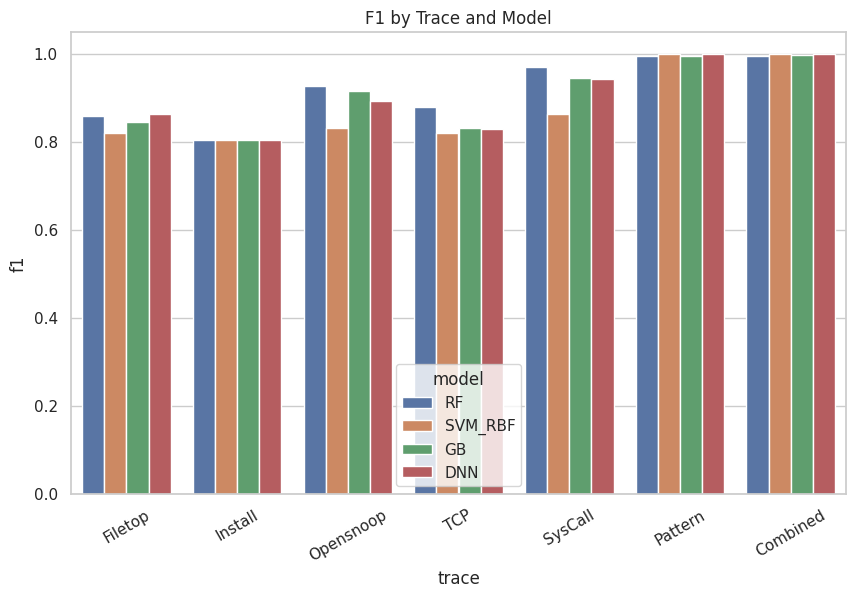

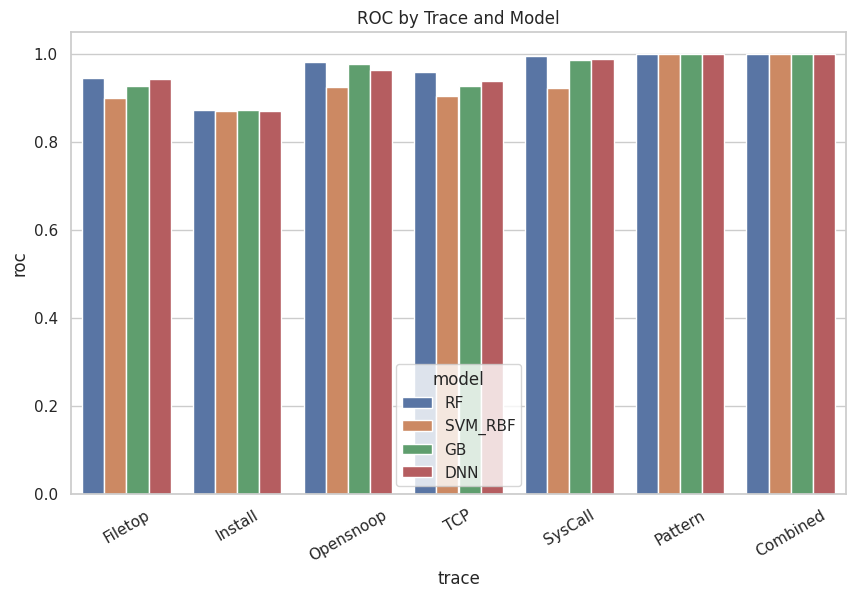

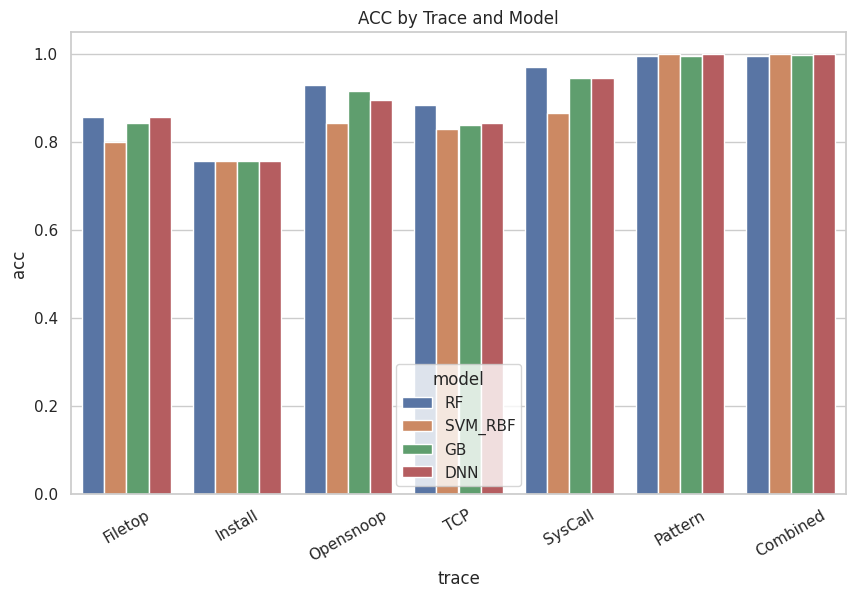

✅ Visualization complete.


In [22]:
# Visual summaries
# Per-trace summary
try:
    import plotly.express as px
    use_plotly = True
except Exception:
    use_plotly = False

# Reload result CSVs if needed
per_trace_csv = OUT_DIR / "per_trace_results.csv"
combined_csv = OUT_DIR / "combined_results.csv"
if per_trace_csv.exists() and combined_csv.exists():
    res_df = pd.read_csv(per_trace_csv)
    comb_df = pd.read_csv(combined_csv)
    fig_df = pd.concat([res_df, comb_df], axis=0)
else:
    fig_df = pd.concat([res_df, comb_df], axis=0)

for metric in ["f1","roc","acc"]:
    plt.figure(figsize=(10,6))
    sns.barplot(data=fig_df, x="trace", y=metric, hue="model")
    plt.title(f"{metric.upper()} by Trace and Model")
    plt.xticks(rotation=30)
    plt.show()

print("✅ Visualization complete.")


In [23]:
# ROC curve helper
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_score, title: str):
    if y_score is None:
        print(f"{title}: No probability scores available; skipping ROC curve.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


**Unsupervised Pipeline**

In [25]:
# Unsupervised anomaly detection helpers (OC-SVM, IsolationForest, Autoencoder)
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

class Autoencoder(nn.Module):
    def __init__(self, in_dim: int, bottleneck: int = 16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(inplace=True),
            nn.Linear(128, 64), nn.ReLU(inplace=True),
            nn.Linear(64, bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 64), nn.ReLU(inplace=True),
            nn.Linear(64, 128), nn.ReLU(inplace=True),
            nn.Linear(128, in_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def fit_threshold_from_val(scores_val: np.ndarray, y_val: np.ndarray, maximize_metric: str = "f1") -> float:
    # scores_val: higher means more anomalous
    # choose threshold that maximizes the chosen metric on val
    thresholds = np.quantile(scores_val, np.linspace(0.5, 0.99, 50))
    best_thr, best_f1 = thresholds[0], -1
    for thr in thresholds:
        y_pred = (scores_val >= thr).astype(int)
        f1 = f1_score(y_val, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr

def evaluate_anomaly_scores(y_true: np.ndarray, scores: np.ndarray, thr: float) -> dict:
    y_pred = (scores >= thr).astype(int)
    mets = compute_metrics(y_true, y_pred, y_score=scores)
    return mets, y_pred

# Train OC-SVM on benign-only, get anomaly scores (-decision_function)
def run_one_class_svm(Xtr_benign: pd.DataFrame, Xva: pd.DataFrame, Xte: pd.DataFrame,
                      yva: pd.Series, yte: pd.Series) -> tuple:
    oc = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
    oc.fit(Xtr_benign)
    # decision_function: positive for inliers; convert to anomaly score (higher=worse)
    s_val = -oc.decision_function(Xva)
    s_test = -oc.decision_function(Xte)
    thr = fit_threshold_from_val(s_val, yva.values)
    mets, ypred = evaluate_anomaly_scores(yte.values, s_test, thr)
    return oc, mets, s_test, thr

# IsolationForest

def run_isolation_forest(Xtr_benign: pd.DataFrame, Xva: pd.DataFrame, Xte: pd.DataFrame,
                         yva: pd.Series, yte: pd.Series) -> tuple:
    iso = IsolationForest(n_estimators=300, contamination=0.05, random_state=RANDOM_SEED, n_jobs=-1)
    iso.fit(Xtr_benign)
    # score_samples: higher => more normal; convert to anomaly score (lower normal)
    s_val = -iso.score_samples(Xva)
    s_test = -iso.score_samples(Xte)
    thr = fit_threshold_from_val(s_val, yva.values)
    mets, ypred = evaluate_anomaly_scores(yte.values, s_test, thr)
    return iso, mets, s_test, thr

# Autoencoder reconstruction error

def run_autoencoder(Xtr_benign: pd.DataFrame, Xva: pd.DataFrame, Xte: pd.DataFrame,
                    yva: pd.Series, yte: pd.Series, epochs=40, batch=256, bottleneck=16) -> tuple:
    in_dim = Xtr_benign.shape[1]
    ae = Autoencoder(in_dim, bottleneck=bottleneck).to(DEVICE)
    opt = torch.optim.AdamW(ae.parameters(), lr=1e-3, weight_decay=1e-5)
    crit = nn.MSELoss()
    tr_loader = DataLoader(torch.tensor(Xtr_benign.values, dtype=torch.float32), batch_size=batch, shuffle=True, num_workers=2, pin_memory=True)

    best_val = float('inf'); patience=6; bad=0
    # Build val tensor once
    Xva_t = torch.tensor(Xva.values, dtype=torch.float32).to(DEVICE)
    for ep in range(1, epochs+1):
        ae.train(); losses=[]
        for xb in tr_loader:
            xb = xb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            recon = ae(xb)
            loss = crit(recon, xb)
            loss.backward();
            torch.nn.utils.clip_grad_norm_(ae.parameters(), max_norm=1.0)
            opt.step(); losses.append(loss.item())
        # val recon error
        ae.eval()
        with torch.no_grad():
            rv = ae(Xva_t)
            val_loss = crit(rv, Xva_t).item()
        if ep==1 or ep%5==0:
            print(f"AE Epoch {ep}/{epochs} train={np.mean(losses):.4f} val={val_loss:.4f}")
        if val_loss < best_val - 1e-5:
            best_val = val_loss; bad=0
            torch.save(ae.state_dict(), OUT_DIR/"best_ae.pth")
        else:
            bad += 1
            if bad >= patience:
                print("AE early stopping."); break
    ae.load_state_dict(torch.load(OUT_DIR/"best_ae.pth", map_location=DEVICE))

    # Scores
    with torch.no_grad():
        s_val = ((ae(Xva_t) - Xva_t)**2).mean(dim=1).cpu().numpy()
        Xte_t = torch.tensor(Xte.values, dtype=torch.float32).to(DEVICE)
        s_test = ((ae(Xte_t) - Xte_t)**2).mean(dim=1).cpu().numpy()
    thr = fit_threshold_from_val(s_val, yva.values)
    mets, ypred = evaluate_anomaly_scores(yte.values, s_test, thr)
    return ae, mets, s_test, thr




=== Unsupervised: Filetop ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


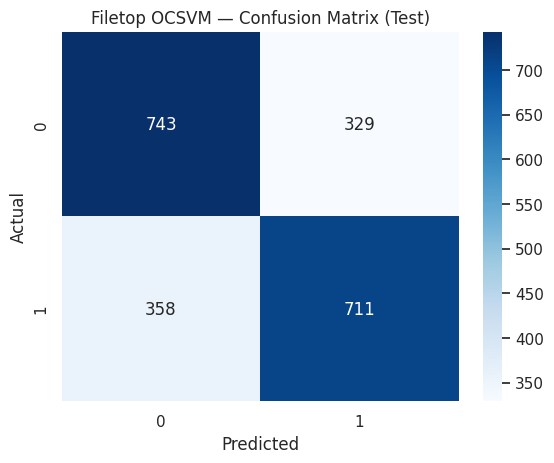

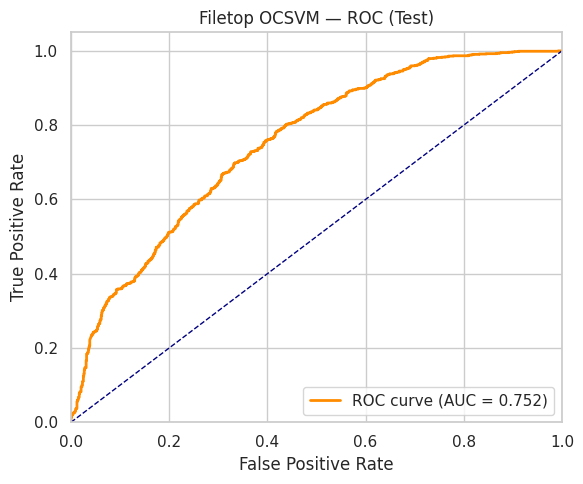

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


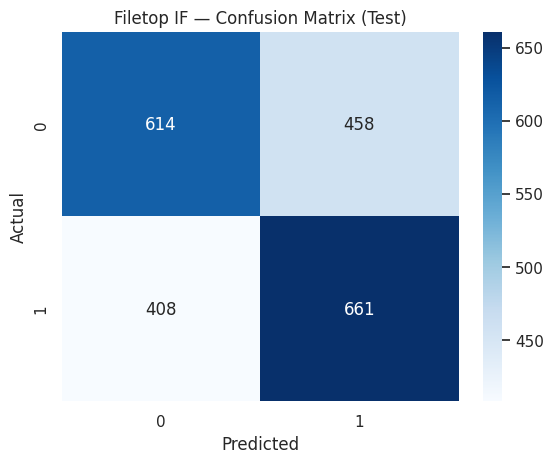

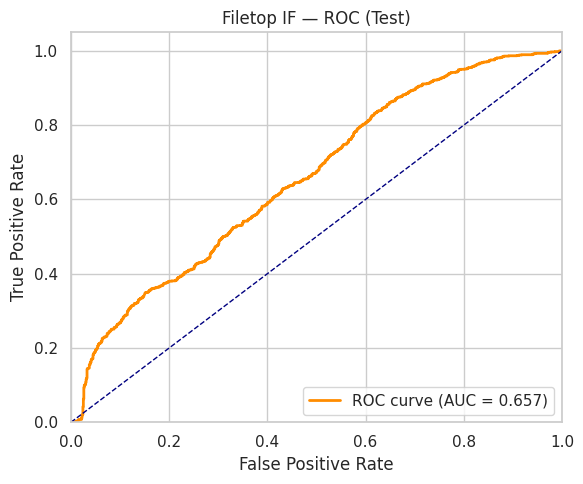

AE Epoch 1/30 train=0.0085 val=0.0066
AE Epoch 5/30 train=0.0004 val=0.0011
AE Epoch 10/30 train=0.0001 val=0.0009
AE Epoch 15/30 train=0.0000 val=0.0009
AE Epoch 20/30 train=0.0000 val=0.0009
AE Epoch 25/30 train=0.0000 val=0.0009
AE Epoch 30/30 train=0.0000 val=0.0009
AE early stopping.


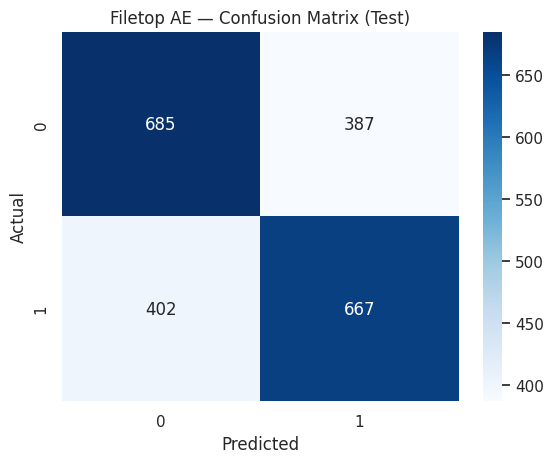

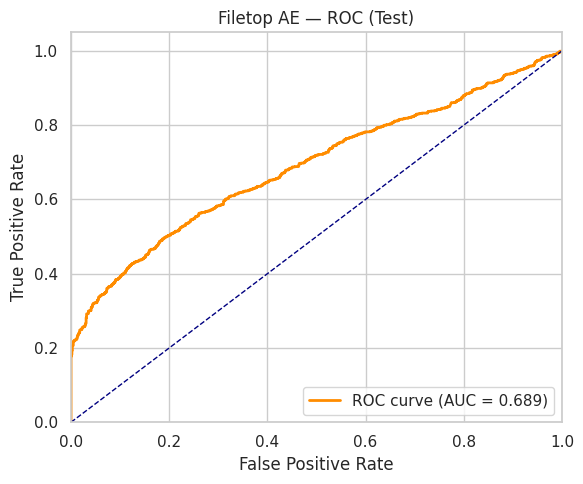


=== Unsupervised: Install ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


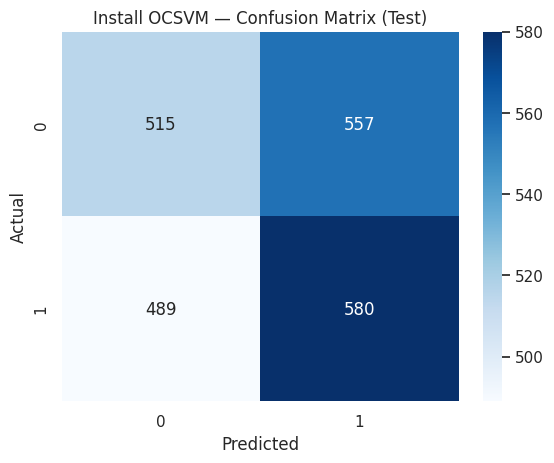

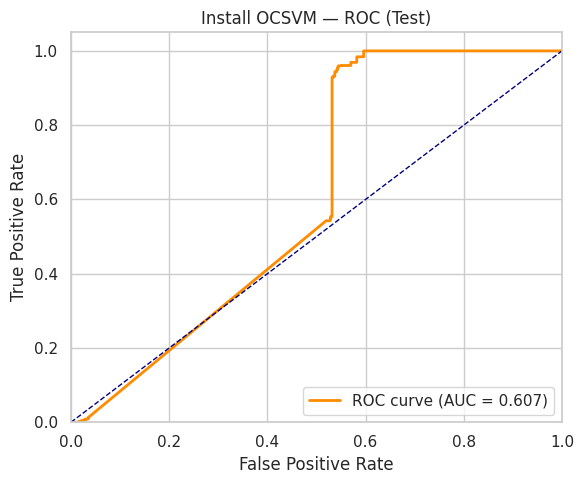

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


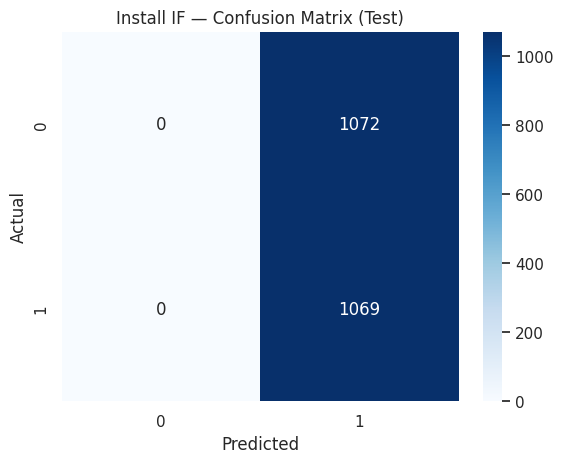

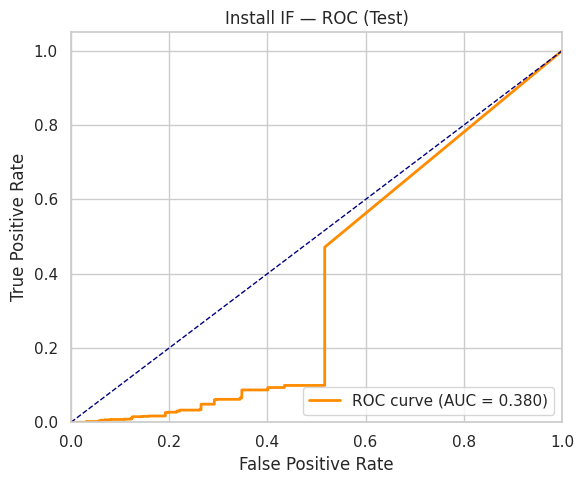

AE Epoch 1/30 train=0.0027 val=0.0013
AE Epoch 5/30 train=0.0004 val=0.0002
AE Epoch 10/30 train=0.0001 val=0.0000
AE Epoch 15/30 train=0.0000 val=0.0000
AE Epoch 20/30 train=0.0000 val=0.0000
AE early stopping.


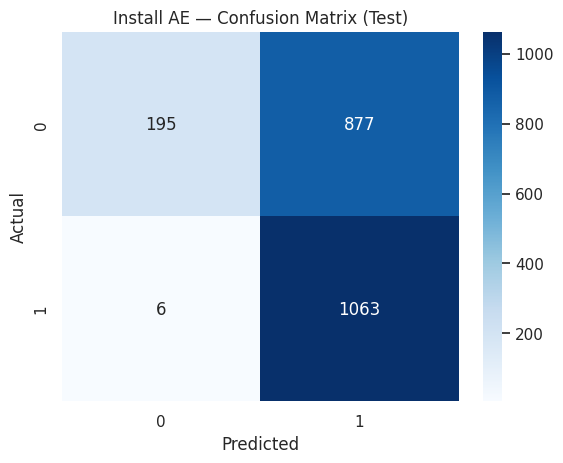

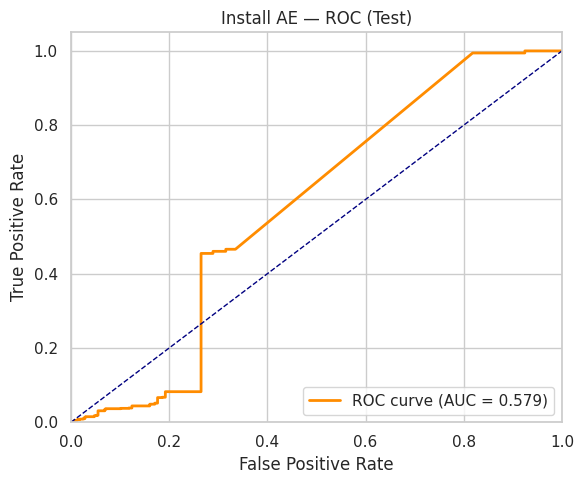


=== Unsupervised: Opensnoop ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


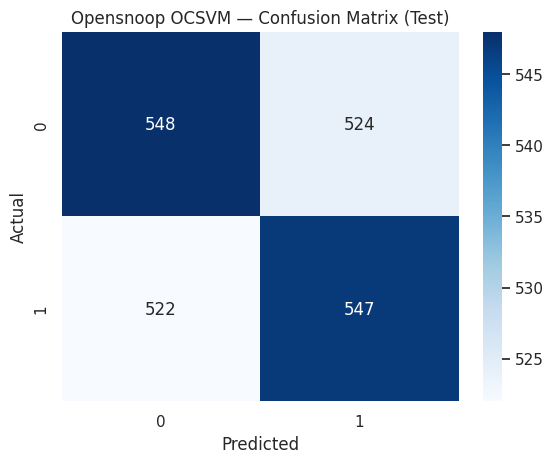

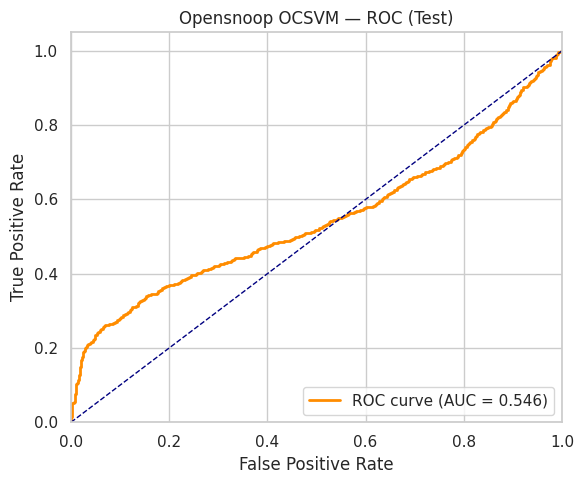

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


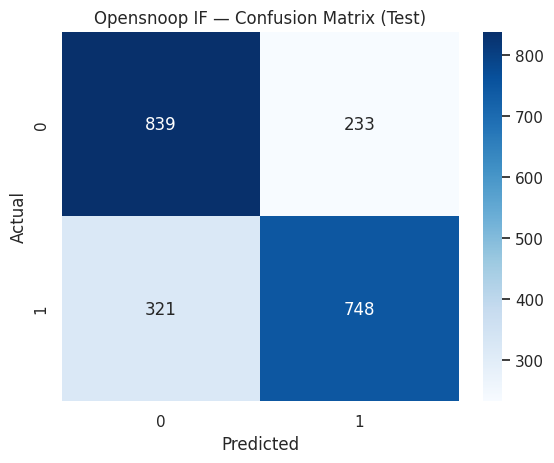

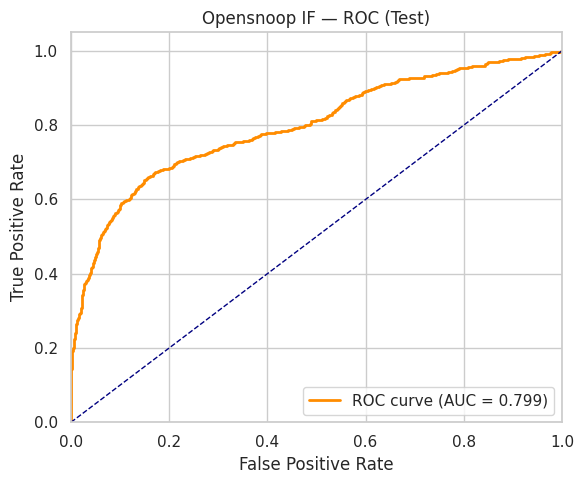

AE Epoch 1/30 train=0.0134 val=0.0074
AE Epoch 5/30 train=0.0013 val=0.0024
AE Epoch 10/30 train=0.0002 val=0.0008
AE Epoch 15/30 train=0.0001 val=0.0008
AE Epoch 20/30 train=0.0001 val=0.0006
AE Epoch 25/30 train=0.0001 val=0.0004
AE Epoch 30/30 train=0.0000 val=0.0003


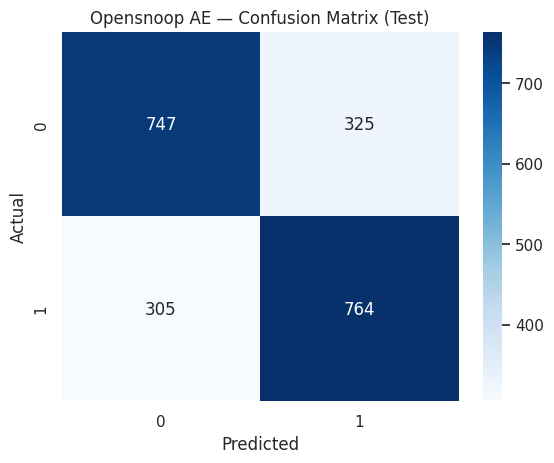

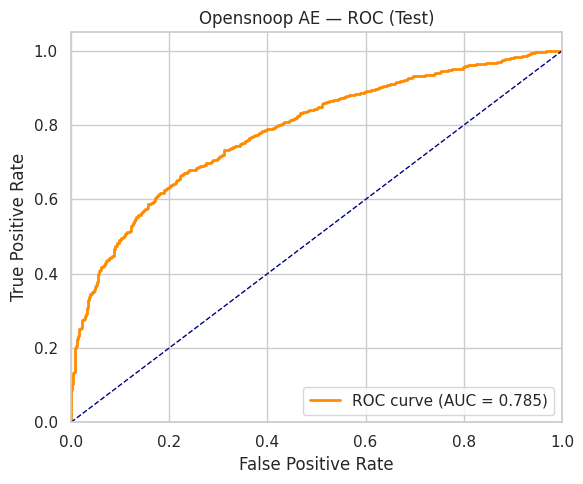


=== Unsupervised: TCP ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


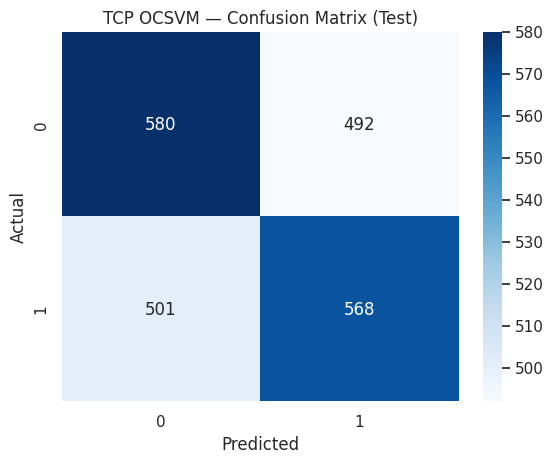

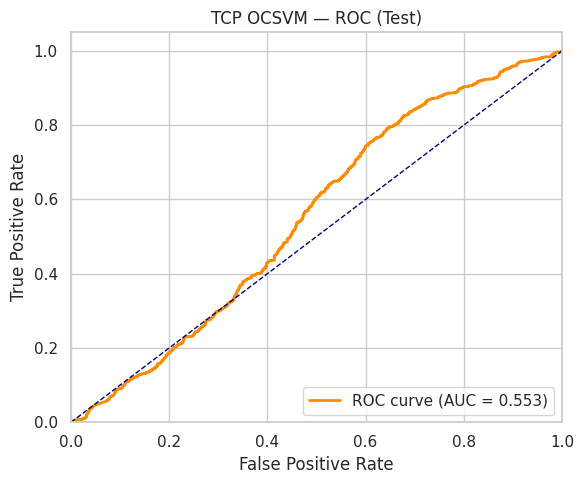

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


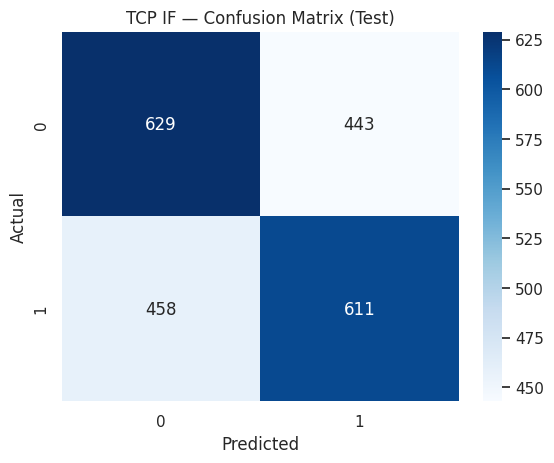

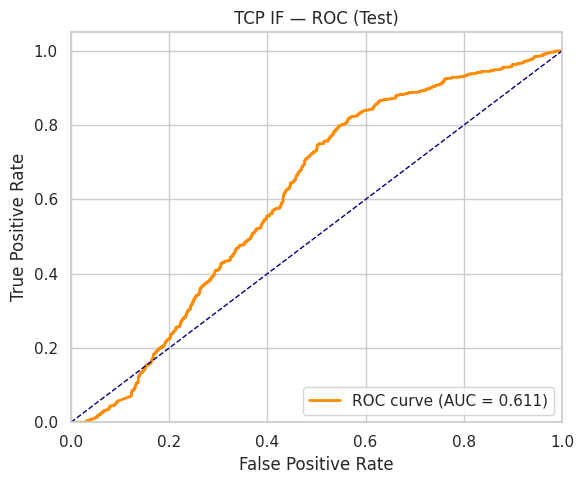

AE Epoch 1/30 train=0.0079 val=0.0040
AE Epoch 5/30 train=0.0012 val=0.0013
AE Epoch 10/30 train=0.0004 val=0.0004
AE Epoch 15/30 train=0.0001 val=0.0002
AE Epoch 20/30 train=0.0000 val=0.0001
AE Epoch 25/30 train=0.0000 val=0.0001
AE Epoch 30/30 train=0.0000 val=0.0000
AE early stopping.


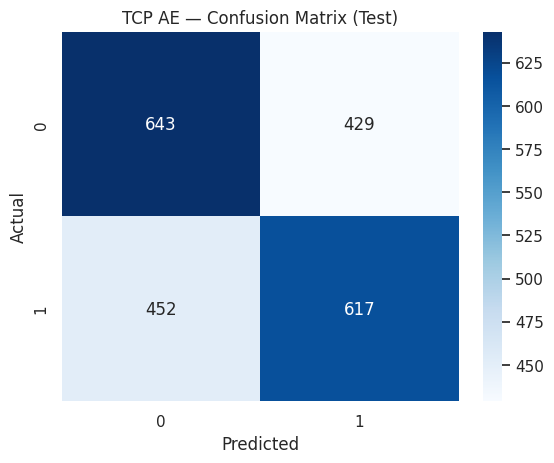

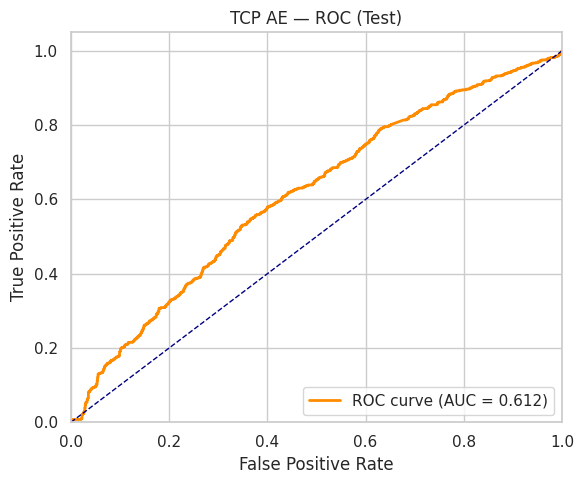


=== Unsupervised: SysCall ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


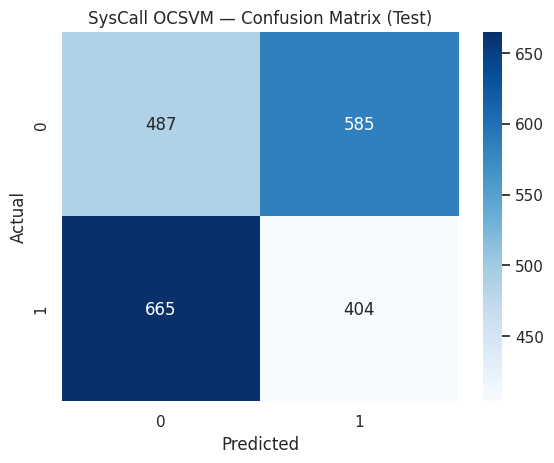

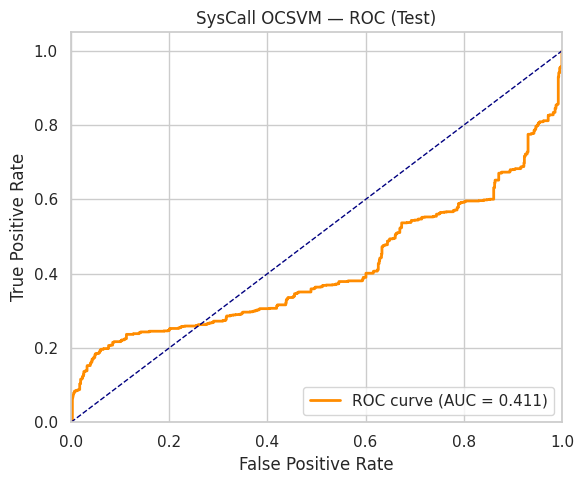

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


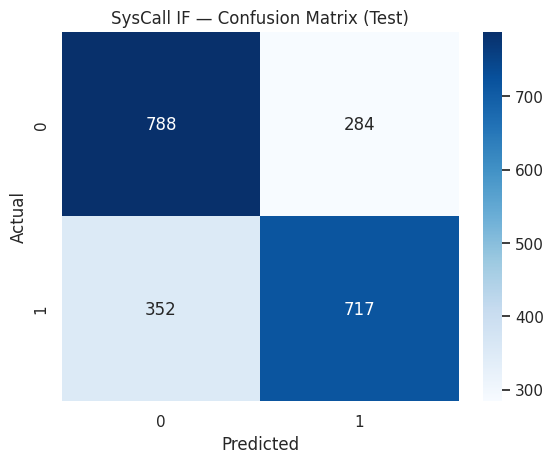

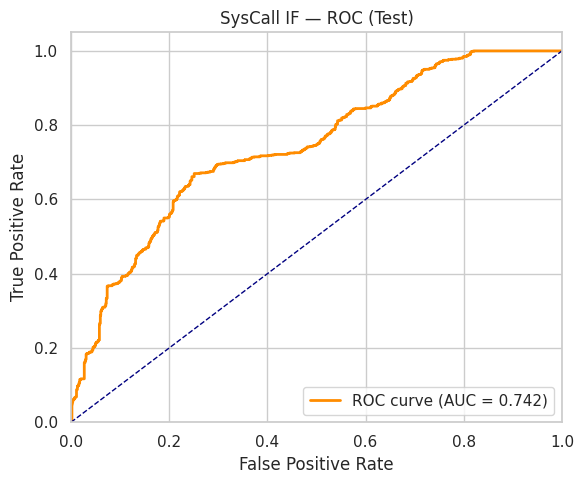

AE Epoch 1/30 train=0.2145 val=0.0663
AE Epoch 5/30 train=0.0173 val=0.0194
AE Epoch 10/30 train=0.0052 val=0.0080
AE Epoch 15/30 train=0.0019 val=0.0051
AE Epoch 20/30 train=0.0014 val=0.0036
AE Epoch 25/30 train=0.0011 val=0.0032
AE Epoch 30/30 train=0.0009 val=0.0030


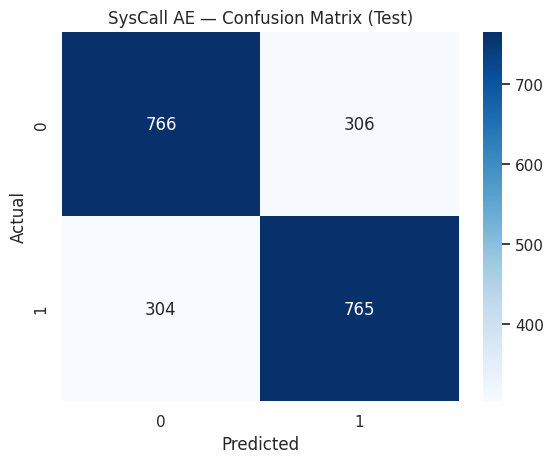

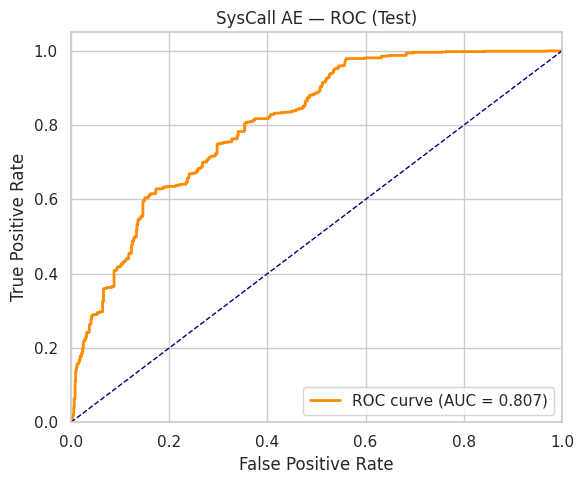


=== Unsupervised: Pattern ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


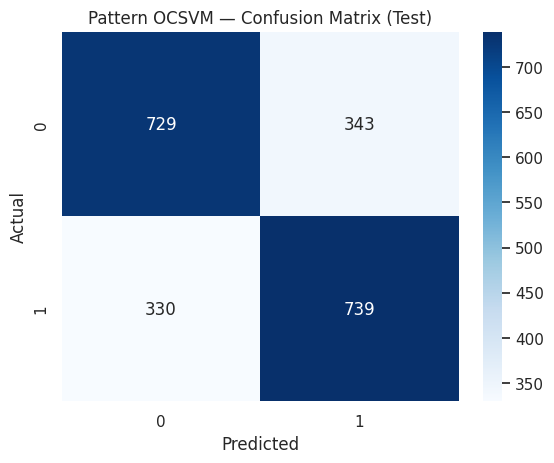

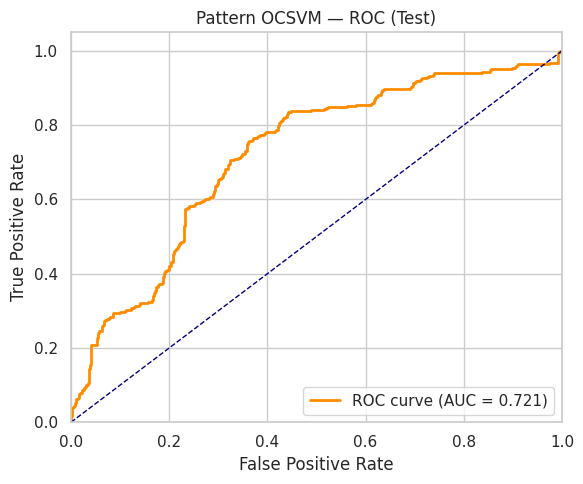

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


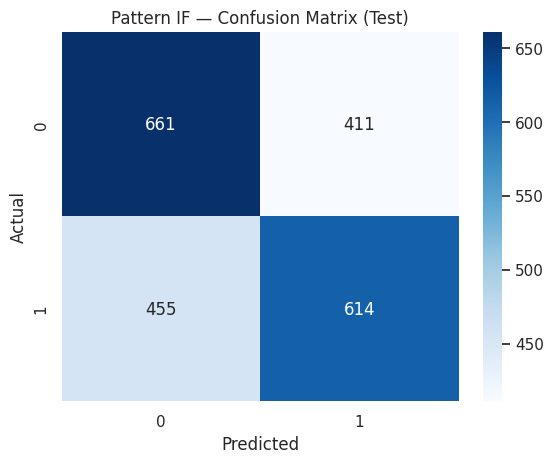

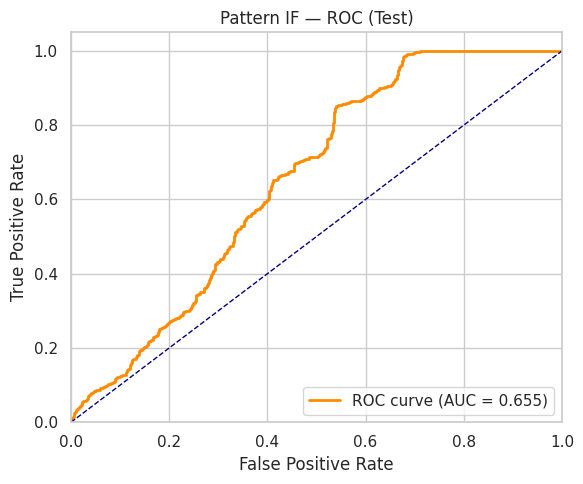

AE Epoch 1/30 train=0.0884 val=0.0279
AE Epoch 5/30 train=0.0075 val=0.0087
AE Epoch 10/30 train=0.0074 val=0.0086
AE Epoch 15/30 train=0.0061 val=0.0075
AE Epoch 20/30 train=0.0055 val=0.0071
AE Epoch 25/30 train=0.0036 val=0.0056
AE Epoch 30/30 train=0.0030 val=0.0052


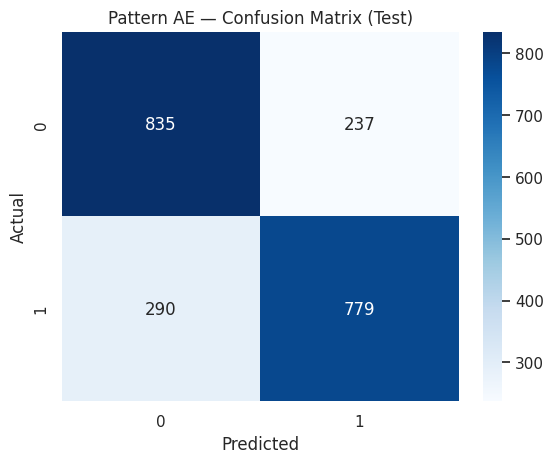

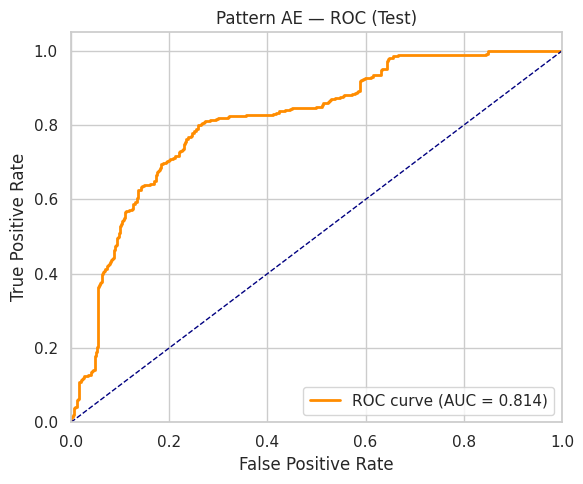

,trace,model,acc,prec,rec,f1,roc
0,Filetop,OCSVM,0.679122,0.683654,0.665108,0.674253,0.751543
1,Filetop,IF,0.595516,0.590706,0.618335,0.604205,0.657185
2,Filetop,AE,0.631481,0.632827,0.623948,0.628356,0.688728
3,Install,OCSVM,0.511443,0.510114,0.542563,0.525839,0.607129
4,Install,IF,0.499299,0.499299,1.000000,0.666044,0.380054
5,Install,AE,0.587576,0.547938,0.994387,0.706547,0.578763
6,Opensnoop,OCSVM,0.511443,0.510738,0.511693,0.511215,0.545837
7,Opensnoop,IF,0.741242,0.762487,0.699719,0.729756,0.798561
8,Opensnoop,AE,0.705745,0.701561,0.714687,0.708063,0.784643
9,TCP,OCSVM,0.536198,0.535849,0.531338,0.533584,0.553095


Saved: /kaggle/working/ai_supplyshield_qut_consolidated/unsupervised_per_trace_results.csv


In [27]:
# Run unsupervised per-trace (using the exact same train-only pipeline outputs)
unsup_rows = []

for trace_name, (X, y) in numeric_traces.items():
    print(f"\n=== Unsupervised: {trace_name} ===")
    Xtr, Xva, Xte, ytr, yva, yte = split_by_indices(X, y)
    pipe = make_tabular_pipeline(corr_thresh=0.9)
    Xtr_s = pipe.fit_transform(Xtr, ytr)
    Xva_s = pipe.transform(Xva)
    Xte_s = pipe.transform(Xte)
    cols = [f"f_{i}" for i in range(Xtr_s.shape[1])]
    Xtr_df = pd.DataFrame(Xtr_s, columns=cols)
    Xva_df = pd.DataFrame(Xva_s, columns=cols)
    Xte_df = pd.DataFrame(Xte_s, columns=cols)

    # Train only on benign subset of train (align indices)
    ytr_r = ytr.reset_index(drop=True)
    mask_benign = (ytr_r == 0).to_numpy()
    Xtr_benign = Xtr_df.iloc[mask_benign]

    # One-Class SVM
    oc, oc_mets, oc_scores, oc_thr = run_one_class_svm(Xtr_benign, Xva_df, Xte_df, yva, yte)
    unsup_rows.append({"trace":trace_name, "model":"OCSVM", **oc_mets})
    joblib.dump(oc, OUT_DIR / f"ocsvm_{trace_name}.joblib")
    show_cm(yte, (oc_scores>=oc_thr).astype(int), title=f"{trace_name} OCSVM — Confusion Matrix (Test)")
    plot_roc(yte, oc_scores, title=f"{trace_name} OCSVM — ROC (Test)")

    # Isolation Forest
    iso, iso_mets, iso_scores, iso_thr = run_isolation_forest(Xtr_benign, Xva_df, Xte_df, yva, yte)
    unsup_rows.append({"trace":trace_name, "model":"IF", **iso_mets})
    joblib.dump(iso, OUT_DIR / f"isof_{trace_name}.joblib")
    show_cm(yte, (iso_scores>=iso_thr).astype(int), title=f"{trace_name} IF — Confusion Matrix (Test)")
    plot_roc(yte, iso_scores, title=f"{trace_name} IF — ROC (Test)")

    # Autoencoder
    ae, ae_mets, ae_scores, ae_thr = run_autoencoder(Xtr_benign, Xva_df, Xte_df, yva, yte, epochs=30, batch=256, bottleneck=16)
    unsup_rows.append({"trace":trace_name, "model":"AE", **ae_mets})
    torch.save(ae.state_dict(), OUT_DIR / f"ae_{trace_name}.pth")
    show_cm(yte, (ae_scores>=ae_thr).astype(int), title=f"{trace_name} AE — Confusion Matrix (Test)")
    plot_roc(yte, ae_scores, title=f"{trace_name} AE — ROC (Test)")

unsup_df = pd.DataFrame(unsup_rows)[["trace","model","acc","prec","rec","f1","roc"]]
display(unsup_df)
unsup_df.to_csv(OUT_DIR/"unsupervised_per_trace_results.csv", index=False)
print("Saved:", OUT_DIR/"unsupervised_per_trace_results.csv")


**Hybrid Approach: Supervised + Unsupervised**

In [28]:
# Hybrid fusion: combine supervised probability and unsupervised anomaly scores
# Strategy: simple weighted late fusion with weights tuned on validation for best F1.

def sigmoid(x):
    return 1/(1+np.exp(-x))

from sklearn.linear_model import LogisticRegression

def fit_hybrid_weights(y_val, sup_prob_val, unsup_scores_val):
    # Normalize unsup scores to [0,1] per trace via rank
    r = pd.Series(unsup_scores_val).rank(pct=True).values
    Xv = np.vstack([sup_prob_val, r]).T
    lr = LogisticRegression(solver='lbfgs', max_iter=500, random_state=RANDOM_SEED)
    lr.fit(Xv, y_val)
    return lr

# Per-trace hybrid using RF probabilities + IsolationForest scores (as a strong baseline)
hybrid_rows = []

for trace_name, (X, y) in numeric_traces.items():
    print(f"\n=== Hybrid: {trace_name} ===")
    # Rebuild splits & pipeline
    Xtr, Xva, Xte, ytr, yva, yte = split_by_indices(X, y)
    pipe = make_tabular_pipeline(corr_thresh=0.9)
    Xtr_s = pipe.fit_transform(Xtr, ytr)
    Xva_s = pipe.transform(Xva)
    Xte_s = pipe.transform(Xte)
    cols = [f"f_{i}" for i in range(Xtr_s.shape[1])]
    Xtr_df = pd.DataFrame(Xtr_s, columns=cols)
    Xva_df = pd.DataFrame(Xva_s, columns=cols)
    Xte_df = pd.DataFrame(Xte_s, columns=cols)

    # Supervised: RF prob
    rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=RANDOM_SEED, n_jobs=-1)
    rf.fit(Xtr_df, ytr)
    sup_prob_val = rf.predict_proba(Xva_df)[:,1]
    sup_prob_test = rf.predict_proba(Xte_df)[:,1]

    # Unsupervised: IsolationForest scores (train on benign only, align indices)
    ytr_r = ytr.reset_index(drop=True)
    mask_benign = (ytr_r == 0).to_numpy()
    iso = IsolationForest(n_estimators=300, contamination=0.05, random_state=RANDOM_SEED, n_jobs=-1)
    iso.fit(Xtr_df.iloc[mask_benign])
    uns_val = -iso.score_samples(Xva_df)
    uns_test = -iso.score_samples(Xte_df)

    # Fit fusion on validation (no test leakage)
    fusion = fit_hybrid_weights(yva.values, sup_prob_val, uns_val)

    # Predict on test via fusion
    r_test = pd.Series(uns_test).rank(pct=True).values
    Xf_test = np.vstack([sup_prob_test, r_test]).T
    fused_prob = fusion.predict_proba(Xf_test)[:,1]
    y_pred = (fused_prob>=0.5).astype(int)
    mets = compute_metrics(yte.values, y_pred, fused_prob)
    hybrid_rows.append({"trace":trace_name, "model":"Hybrid(RF+IF)", **mets})

hyb_df = pd.DataFrame(hybrid_rows)[["trace","model","acc","prec","rec","f1","roc"]]
display(hyb_df)
hyb_df.to_csv(OUT_DIR/"hybrid_per_trace_results.csv", index=False)
print("Saved:", OUT_DIR/"hybrid_per_trace_results.csv")



=== Hybrid: Filetop ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



=== Hybrid: Install ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



=== Hybrid: Opensnoop ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



=== Hybrid: TCP ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



=== Hybrid: SysCall ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



=== Hybrid: Pattern ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,trace,model,acc,prec,rec,f1,roc
0,Filetop,Hybrid(RF+IF),0.860346,0.861163,0.858746,0.859953,0.943820
1,Install,Hybrid(RF+IF),0.757123,0.672750,1.000000,0.804364,0.871290
2,Opensnoop,Hybrid(RF+IF),0.932275,0.937500,0.926099,0.931765,0.983105
3,TCP,Hybrid(RF+IF),0.883699,0.909182,0.852198,0.879768,0.958911
4,SysCall,Hybrid(RF+IF),0.970107,0.969188,0.971001,0.970093,0.995465
5,Pattern,Hybrid(RF+IF),0.994395,0.991628,0.997194,0.994403,0.999906


Saved: /kaggle/working/ai_supplyshield_qut_consolidated/hybrid_per_trace_results.csv
